In [1]:
import pennylane as qml
import torch
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [2]:
import functools
import inspect
import math
from collections.abc import Iterable
from typing import Callable, Dict, Union, Any

from pennylane import QNode

try:
    import torch
    from torch.nn import Module

    TORCH_IMPORTED = True
except ImportError:
    # The following allows this module to be imported even if PyTorch is not installed. Users
    # will instead see an ImportError when instantiating the TorchLayer.
    from unittest.mock import Mock

    Module = Mock
    TORCH_IMPORTED = False


class TorchLayer(Module):
    def __init__(self,qnode,weights):
        if not TORCH_IMPORTED:
            raise ImportError(
                "TorchLayer requires PyTorch. PyTorch can be installed using:\n"
                "pip install torch\nAlternatively, "
                "visit https://pytorch.org/get-started/locally/ for detailed "
                "instructions."
            )
        super().__init__()

        #weight_shapes = {
        #    weight: (tuple(size) if isinstance(size, Iterable) else () if size == 1 else (size,))
        #    for weight, size in weight_shapes.items()
        #}

        # validate the QNode signature, and convert to a Torch QNode.
        # TODO: update the docstring regarding changes to restrictions when tape mode is default.
        #self._signature_validation(qnode, weight_shapes)
        self.qnode = qnode
        self.qnode.interface = "torch"

        self.qnode_weights = weights

    def forward(self, inputs):  # pylint: disable=arguments-differ
        """Evaluates a forward pass through the QNode based upon input data and the initialized
        weights.

        Args:
            inputs (tensor): data to be processed

        Returns:
            tensor: output data
        """

        if len(inputs.shape) > 1:
            # If the input size is not 1-dimensional, unstack the input along its first dimension,
            # recursively call the forward pass on each of the yielded tensors, and then stack the
            # outputs back into the correct shape
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)

        # If the input is 1-dimensional, calculate the forward pass as usual
        return self._evaluate_qnode(inputs)


    def _evaluate_qnode(self, x):
        """Evaluates the QNode for a single input datapoint.

        Args:
            x (tensor): the datapoint

        Returns:
            tensor: output datapoint
        """
        kwargs = {
            **{self.input_arg: x},
            **{arg: weight.to(x) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)

        if isinstance(res, torch.Tensor):
            return res.type(x.dtype)

        return torch.hstack(res).type(x.dtype)

    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(alpha, img_shape=(8,8), patch_shape=(49,49)):
    """
    alpha: Attention values (torch tensor or numpy array)
    img_shape: Shape of the original image (height, width)
    patch_shape: Shape of the patch (height, width)
    """
    # Reshape alpha to match image shape
    alpha = alpha.detach().numpy() if isinstance(alpha, torch.Tensor) else alpha
    attention_map = np.mean(alpha, axis=0).reshape(patch_shape)  # Mean over the sequence
    
    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    
    # Calculate the sum of each row (goro 합)
    row_sums = np.sum(attention_map, axis=1)
    print("Row sums:", row_sums)

    # Plot the attention map
    plt.figure(figsize=(6, 6))
    sns.heatmap(attention_map, annot=False, cmap="YlGnBu", cbar=True)
    plt.title("Attention Map")
    plt.show()

    # Plot bar chart for the row sums
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(row_sums)), row_sums, color='blue')
    plt.title("Sums of Attention Coefficients by Patch Index")
    plt.xlabel("Patch Index")
    plt.ylabel("Sum of Attention Coefficients")
    
    # Set x-axis ticks to be integers only
    plt.xticks(np.arange(len(row_sums)), np.arange(len(row_sums)).astype(int))
    plt.show()

In [4]:
def set_random_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)

In [5]:
class QSAL_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D):
        super().__init__()
        self.seq_num=S
        self.init_params_Q=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_K=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_V=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.num_q=n
        self.Denc=Denc
        self.D=D
        self.d=n*(Denc+2)
        self.dev = qml.device("default.qubit", wires=self.num_q)
        
        self.vqnod=qml.QNode(self.circuit_v, self.dev, interface="torch")
        self.qnod=qml.QNode(self.circuit_qk, self.dev, interface="torch")
        self.weight_v = [{"weights": self.init_params_V[i]} for i in range(self.seq_num)]
        self.weight_q = [{"weights": self.init_params_Q[i]} for i in range(self.seq_num)]
        self.weight_k = [{"weights": self.init_params_K[i]} for i in range(self.seq_num)]
        #self.v_linear ={} #[qml.qnn.TorchLayer(self.vqnod[i], self.weight_shapes) for i in range(self.seq_num)]
        #for i in range(self.seq_num):
        self.v_linear = [TorchLayer(self.vqnod, self.weight_v[i]) for i in range(self.seq_num)]
        self.q_linear = [TorchLayer(self.qnod, self.weight_q[i]) for i in range(self.seq_num)]
        self.k_linear = [TorchLayer(self.qnod, self.weight_k[i]) for i in range(self.seq_num)]
        #self.qqnod=[qml.QNode(self.circuit_qk, self.dev, interface="torch") for i in range(self.seq_num)]
        
        # Add a variable to store the alpha values
        self.alpha = None

    def random_op(self):
        # 무작위 시드 고정
        set_random_seed(42)  # 원하는 시드 값 설정
        a=random.randint(0, 4)
        if a==0:
            op=qml.Identity(0)
        elif a==1:
            op=qml.PauliX(0)
        elif a==2:
            op=qml.PauliY(0)
        else:
            op=qml.PauliZ(0)

        op_elimated=qml.Identity(0)
        for i in range(1,self.num_q):
            op_elimated=op_elimated@qml.Identity(i)
        Select_wrong=True
        while Select_wrong:
            for i in range(1,self.num_q):
                a=random.randint(0, 4)
                if a==0:
                    op=op@qml.Identity(i)
                elif a==1:
                    op=op@qml.PauliX(i)
                elif a==2:
                    op=op@qml.PauliY(i)
                else:
                    op=op@qml.PauliZ(i)
            if op!=op_elimated:
                Select_wrong=False
        return op

    def circuit_v(self,inputs,weights):
            op=self.random_op()
            # feature_map
            indx=0
            for j in range(self.num_q):
                qml.RX(inputs[indx],j)
                qml.RY(inputs[indx+1],j)
                indx+=2
            for i in range(self.Denc):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))

                for j in range(self.num_q):
                    qml.RY(inputs[indx],j)
                    indx+=1
            # Ansatz
            indx=0
            for j in range(self.num_q):
                qml.RX(weights[indx],j)
                qml.RY(weights[indx+1],j)
                indx+=2
            for i in range(self.D):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
                for j in range(self.num_q):
                    #qc.rx(params[indx],j)
                    qml.RY(weights[indx],j)
                    indx+=1
            return [qml.expval(op) for i in range(self.d)] 

    def circuit_qk(self,inputs,weights):
        op=self.random_op()
        # feature_map
        indx=0
        for j in range(self.num_q):
            qml.RX(inputs[indx],j)
            qml.RY(inputs[indx+1],j)
            indx+=2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))

            for j in range(self.num_q):
                qml.RY(inputs[indx],j)
                indx+=1
        # Ansatz
        indx=0
        for j in range(self.num_q):
            qml.RX(weights[indx],j)
            qml.RY(weights[indx+1],j)
            indx+=2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))
                
            for j in range(self.num_q):
                #qc.rx(params[indx],j)
                qml.RY(weights[indx],j)
                indx+=1
        return [qml.expval(qml.PauliZ(0))]

    def forward(self,input):

        Q_output=torch.stack([self.q_linear[i](input[:,i]) for i in range(self.seq_num)])
        K_output=torch.stack([self.k_linear[i](input[:,i]) for i in range(self.seq_num)])
        V_output=torch.stack([self.v_linear[i](input[:,i]) for i in range(self.seq_num)])
    
        Q_output=Q_output.transpose(0,2).repeat((self.seq_num,1,1))
        K_output=K_output.transpose(0,2).repeat((self.seq_num,1,1)).transpose(0,2)

        
        # Calculate alpha and store it in the instance variable
        self.alpha = torch.exp(-(Q_output - K_output)**2).transpose(0, 1)
        # Example usage:
        visualize_attention(self.alpha)
        V_output=V_output.transpose(0,1)
        output=[]
        
        # print("Q_output size:", Q_output.size())
        # print("K_output size:", K_output.size())
        # print("V_output size:", V_output.size())


        for i in range(self.seq_num):
            
            Sum_a=torch.sum(self.alpha[:,i,:],-1)
            div_sum_a=(1/Sum_a).repeat(self.d,self.seq_num,1).transpose(0,2)
            
            Sum_w=torch.sum(self.alpha[:,:,i].repeat((self.d,1,1)).transpose(0,2).transpose(0,1)*V_output*div_sum_a,1)
            output.append(Sum_w)
        return input+torch.stack(output).transpose(0,1)


class QSANN_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.qsal_lst=[QSAL_pennylane(S,n,Denc,D) for _ in range(num_layers)]
        self.qnn=nn.Sequential(*self.qsal_lst)

    def forward(self,input):
        return self.qnn(input)

class QSANN_text_classifier(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.Qnn=QSANN_pennylane(S,n,Denc,D,num_layers)
        self.final_layer=nn.Linear(n*(Denc+2)*S, 1)
        self.final_layer=self.final_layer.float()

    def forward(self,input):
        print(input.shape)
        x=self.Qnn(input)
        x=torch.flatten(x,start_dim=1)
        # print('done2')
        output = torch.sigmoid(self.final_layer(x))
        # print('done3')
        return output

In [6]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

# MNIST 데이터 불러오기
(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

# 데이터 정규화 (0-255 값을 0-1 사이로)
X_train_full = X_train_full.astype('float32') / 255.0
X_test_full = X_test_full.astype('float32') / 255.0

#torch.transform / normalize // imagenet mean sd 

# 숫자 1과 7만 선택하는 마스크 생성
train_mask = np.isin(y_train_full, [1, 7])
X_train, y_train = X_train_full[train_mask], y_train_full[train_mask]

test_mask = np.isin(y_test_full, [1, 7])
X_test, y_test = X_test_full[test_mask], y_test_full[test_mask]

# 시드 고정 (예: 42로 고정)
np.random.seed(42)

# 2000개의 데이터를 무작위로 선택
num_samples = 200
indices = np.random.choice(len(X_train), num_samples, replace=False)
X_sampled, y_sampled = X_train[indices], y_train[indices]

# 2000개의 샘플에서 train/test 데이터 분할 (80% train, 20% test 비율로 나눔)
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, stratify=y_sampled,test_size=0.2, random_state=42
)

# 결과
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


2024-11-28 16:10:56.755932: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 16:10:56.784155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 16:10:56.820053: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 16:10:56.831143: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 16:10:56.856963: I tensorflow/core/platform/cpu_feature_guar

Training set size: 160
Test set size: 40


In [7]:
X_train.shape

(160, 28, 28)

In [8]:
# 2x2 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [9]:
# 각 이미지를 2x2 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [10]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{1: 81, 7: 79}


In [11]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_test, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{1: 20, 7: 20}


In [12]:
# Model, optimizer, and criterion setup
model = QSANN_text_classifier(49, 4, 2, 1, 1)
optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [13]:
# Print out the parameters and their shapes
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter name: {name}")
        print(f"Shape: {param.shape}")
        print(f"Number of parameters: {param.numel()}")
        print("-" * 50)

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")


Parameter name: Qnn.qnn.0.init_params_Q
Shape: torch.Size([49, 12])
Number of parameters: 588
--------------------------------------------------
Parameter name: Qnn.qnn.0.init_params_K
Shape: torch.Size([49, 12])
Number of parameters: 588
--------------------------------------------------
Parameter name: Qnn.qnn.0.init_params_V
Shape: torch.Size([49, 12])
Number of parameters: 588
--------------------------------------------------
Parameter name: final_layer.weight
Shape: torch.Size([1, 784])
Number of parameters: 784
--------------------------------------------------
Parameter name: final_layer.bias
Shape: torch.Size([1])
Number of parameters: 1
--------------------------------------------------
Total number of trainable parameters: 2549


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


torch.Size([2, 49, 16])
Row sums: [40.66031  43.101597 43.00385  43.60677  43.351406 40.694447 41.55858
 43.109303 39.564556 42.62785  30.834595 38.11132  37.58071  43.56942
 42.480324 37.80978  29.336985 37.014355 42.05577  31.795353 42.95647
 43.760532 43.691784 41.728447 39.509453 40.43464  43.344254 40.411327
 33.16117  41.2954   41.996223 39.247955 39.29098  40.03783  40.270866
 43.21325  42.208588 36.635544 40.758263 38.512203 42.95542  40.289936
 43.711765 37.001534 43.41406  42.74707  42.556164 43.47889  40.339203]


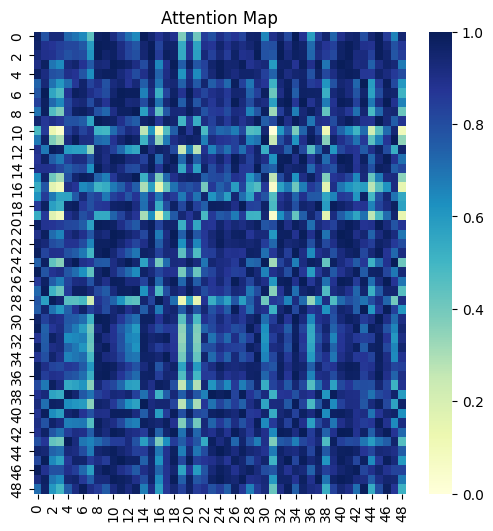

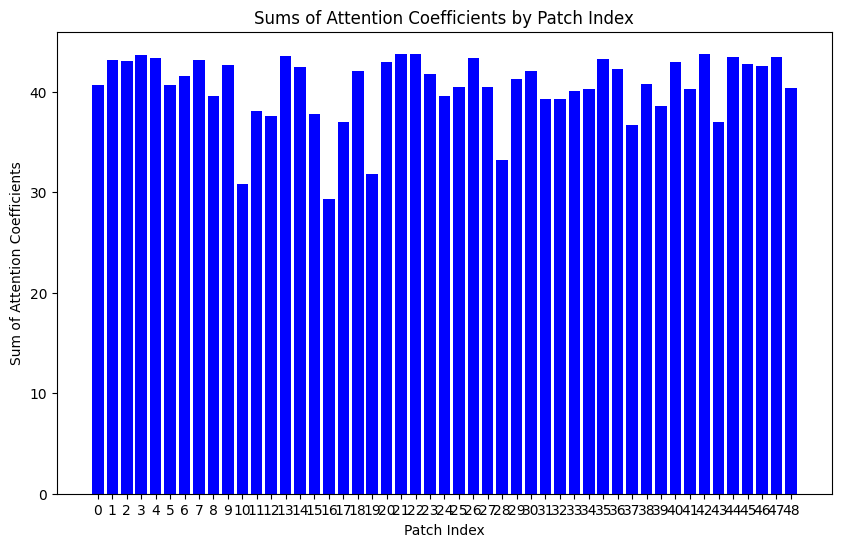

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    QSAL_pennylane-1               [-1, 49, 16]               0
   QSANN_pennylane-2               [-1, 49, 16]               0
            Linear-3                    [-1, 1]             785
Total params: 785
Trainable params: 785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [14]:
from torchsummary import summary
summary(model, input_size=(49, 16))  # (sequence_length, embed_size)


In [13]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [27]:
# 학습 후 모델 파라미터 저장 경로
model_save_path = "/home/jaeyeob/QVT/result/MNIST/qsann_classifier_1.pth"

In [28]:
# Attention value extraction (after forward pass, assuming attention is part of the output)
class AttentionExtractor(QSANN_text_classifier):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__(S, n, Denc, D, num_layers)
        self.attention_values = None

    def forward(self, input):
        x = self.Qnn(input)
        x = torch.flatten(x, start_dim=1)
        
        # Extract attention values from the QSAL layers (assuming alpha in the QSAL_pennylane)
        self.attention_values = self.Qnn.qsal_lst[0].alpha  # Example for first QSAL layer
        output = torch.sigmoid(self.final_layer(x))
        return output


In [29]:
# Create an instance of the new model with attention extraction
attention_model = AttentionExtractor(49, 4, 2, 1, 1)
attention_model.load_state_dict(torch.load(model_save_path))
attention_model.eval()

AttentionExtractor(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=784, out_features=1, bias=True)
)

In [30]:
# # Training the model
# for iepoch in tqdm(range(20)):
#     optimizer.zero_grad()
#     X_tensor = torch.tensor(X_train)
#     predictions = model(X_tensor.float()).squeeze(1)
    
#     label = torch.tensor(y_train)
#     for i in range(len(label)):
#         label[i] = 0 if label[i] == 1 else 1
    
#     loss = criterion(predictions, label.float())
#     acc = binary_accuracy(predictions, label)
#     print(f'Accuracy: {acc}')
#     print(f'Loss: {loss}')
    
#     loss.backward()
#     optimizer.step()
#     print(f"Complete {iepoch} th")

# # Save the model parameters
# torch.save(model.state_dict(), model_save_path)
# print("Model parameters saved.")

Row sums: [46.74844  46.704178 46.414223 15.444092 44.42479  46.761734 46.753185
 19.887728 46.643456 45.65942  37.561104 45.28179  44.628746 46.13004
 19.073687 46.307377 43.189022 44.991364 44.857334 46.29487  42.85544
 46.761963 37.146572 46.177063 45.72722  44.246777 43.33694  45.533844
 46.6935   41.20823  46.72157  44.87861  46.178555 46.525566 42.310455
 45.077904 46.45116  42.854378 44.444576 45.13862  46.701706 46.754696
 39.86284  41.67335  46.629745 46.543247 44.94335  35.315365 46.724705]


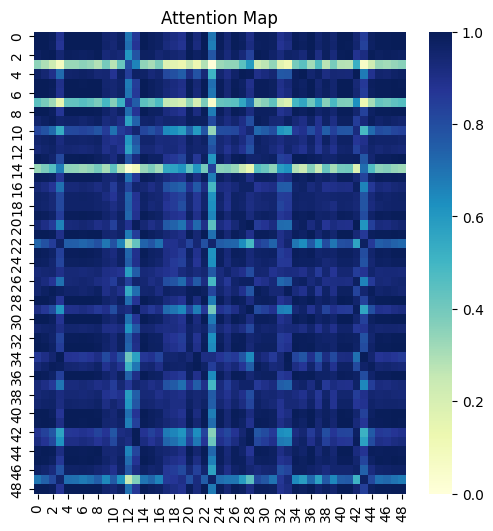

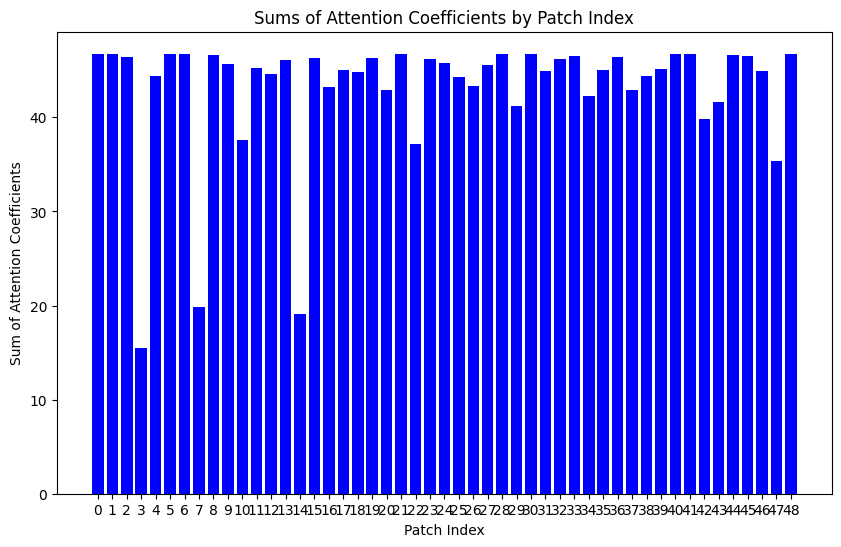


Accuracy: 1.0

Loss: 66.45342254638672

AUROC: 1.0

Precision: 1.0

Recall: 1.0

F1 Score: 1.0

AUPRC: 1.0



/tmp/ipykernel_310226/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


In [31]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, average_precision_score

# Convert test data to tensor
X_tensor = torch.tensor(X_test)
predictions = attention_model(X_tensor.float()).squeeze(1)
label = torch.tensor(y_test)

# Reverse the labels (if needed)
for i in range(len(label)):
    if label[i] == 1:
        label[i] = 0
    else:
        label[i] = 1

# Calculate loss and accuracy
loss = criterion(predictions, label.float())
acc = binary_accuracy(predictions, label.float())

# Convert predictions and labels to numpy for sklearn metrics
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy

# Calculate AUROC
auroc = roc_auc_score(labels_np, preds_np)

# Binarize predictions for precision, recall, and F1 calculation
binary_preds = np.where(preds_np > 0.5, 1, 0)

# Calculate Precision, Recall, and F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(labels_np, binary_preds, average='binary')

# Calculate AUPRC (Area Under the Precision-Recall Curve)
auprc = average_precision_score(labels_np, preds_np)

# Print results
print(f'\nAccuracy: {acc}\n')
print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')
print(f'Precision: {precision}\n')
print(f'Recall: {recall}\n')
print(f'F1 Score: {f1}\n')
print(f'AUPRC: {auprc}\n')


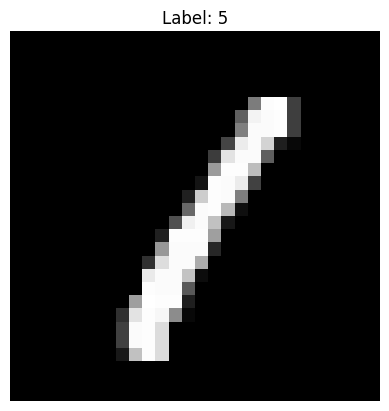

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt

# MNIST 데이터셋 로드
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# 첫 번째 샘플 추출
image = train_images[3]

# 이미지 시각화
plt.imshow(image, cmap='gray')
plt.title(f'Label: {train_labels[0]}')
plt.axis('off')
plt.show()


In [16]:
single = np.array([split_into_non_overlapping_patches(image)])

In [20]:
# Select a single sample from the test set
single_sample = torch.tensor(single.astype(np.float32))  # Select one sample


In [21]:
# Attention value extraction (after forward pass, assuming attention is part of the output)
class AttentionExtractor(QSANN_text_classifier):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__(S, n, Denc, D, num_layers)
        self.attention_values = None

    def forward(self, input):
        x = self.Qnn(input)
        x = torch.flatten(x, start_dim=1)
        
        # Extract attention values from the QSAL layers (assuming alpha in the QSAL_pennylane)
        self.attention_values = self.Qnn.qsal_lst[0].alpha  # Example for first QSAL layer
        output = torch.sigmoid(self.final_layer(x))
        return output


In [22]:
# Create an instance of the new model with attention extraction
attention_model = AttentionExtractor(49, 4, 2, 1, 1)
attention_model.load_state_dict(torch.load(model_save_path))
attention_model.eval()

AttentionExtractor(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=784, out_features=1, bias=True)
)

Row sums: [47.122387 47.061752 46.89281  16.05906  44.651615 47.154594 47.13016
 20.363426 47.081963 45.879677 41.13637  47.156906 47.156185 46.41584
 20.07061  47.1532   46.01614  46.539036 46.95546  47.089355 43.076134
 47.15387  37.748108 46.308334 45.022243 46.93392  43.2852   46.100067
 47.04832  41.319622 47.10166  46.190865 46.81015  46.852455 43.068386
 45.67825  46.806484 45.930614 46.93754  47.15534  47.05862  47.156876
 40.047688 41.70438  44.48852  47.080894 45.692978 36.35162  47.08847 ]


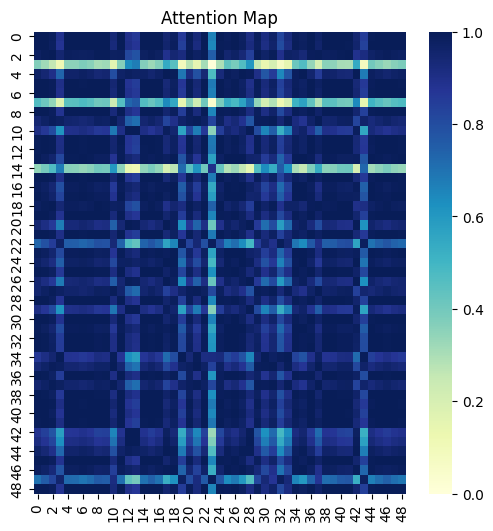

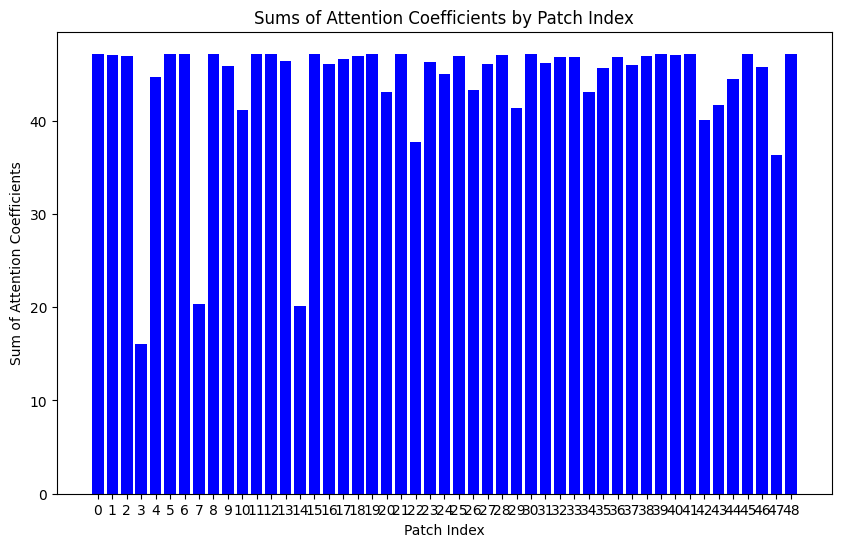

Predicted class for the sample: 0.0
Row sums: [47.122387 47.061752 46.89281  16.05906  44.651615 47.154594 47.13016
 20.363426 47.081963 45.879677 41.13637  47.156906 47.156185 46.41584
 20.07061  47.1532   46.01614  46.539036 46.95546  47.089355 43.076134
 47.15387  37.748108 46.308334 45.022243 46.93392  43.2852   46.100067
 47.04832  41.319622 47.10166  46.190865 46.81015  46.852455 43.068386
 45.67825  46.806484 45.930614 46.93754  47.15534  47.05862  47.156876
 40.047688 41.70438  44.48852  47.080894 45.692978 36.35162  47.08847 ]


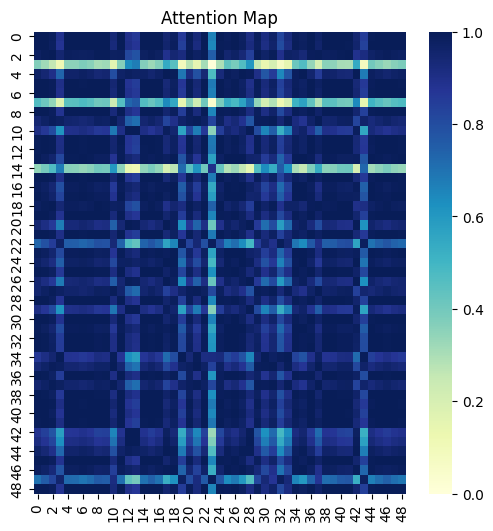

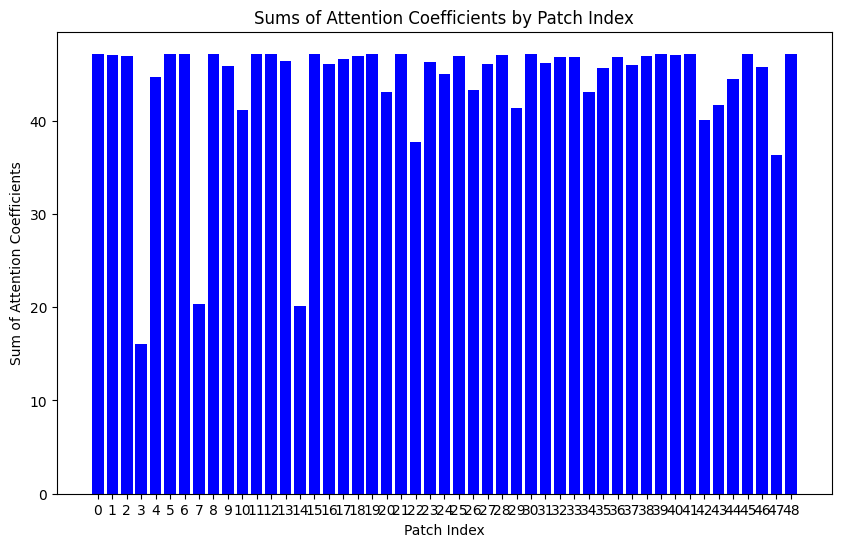

Extracted attention values: tensor([[[0.9986, 0.9994, 0.9890,  ..., 0.9999, 0.9992, 0.9977],
         [0.9996, 0.9982, 0.9850,  ..., 0.9992, 0.9999, 0.9991],
         [0.9809, 0.9942, 1.0000,  ..., 0.9919, 0.9834, 0.9780],
         ...,
         [0.9878, 0.9704, 0.9376,  ..., 0.9750, 0.9857, 0.9900],
         [0.7253, 0.7756, 0.8358,  ..., 0.7645, 0.7330, 0.7168],
         [0.9993, 0.9987, 0.9866,  ..., 0.9995, 0.9997, 0.9986]]])


In [23]:
# Make a prediction for the single sample
# Get the attention values for a single sample
with torch.no_grad():
    prediction = attention_model(single_sample).squeeze()
    predicted_class = (torch.round(prediction)).item()
    print(f"Predicted class for the sample: {predicted_class}")

    _ = attention_model(single_sample)  # Forward pass to calculate attention
    attention_values = attention_model.attention_values  # Extracted attention values
    print(f"Extracted attention values: {attention_values}")

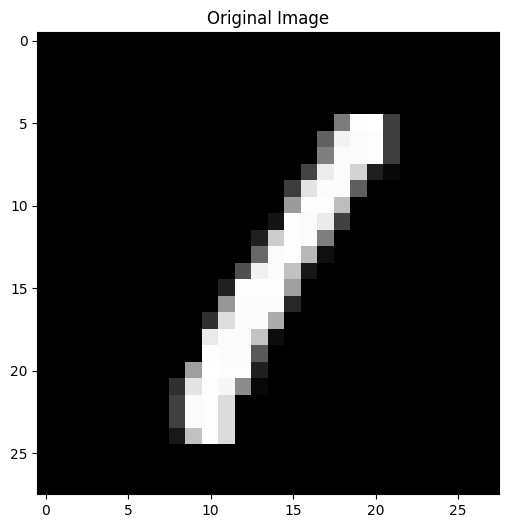

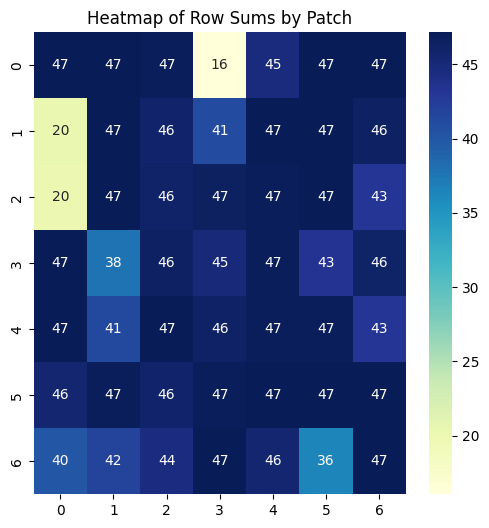

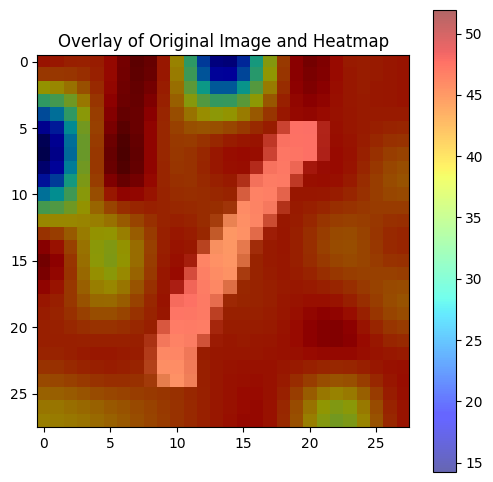

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_sample_and_heatmap(sample, row_sums, patch_shape=(7, 7)):
    """
    sample: The original image (2D numpy array)
    row_sums: The sums corresponding to each patch
    patch_shape: Shape of the patch grid (e.g., (2, 2))
    """
    # 1. Plot the original sample image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title("Original Image")
    plt.show()

    # 2. Create the heatmap using the row sums
    heatmap_values = np.array(row_sums).reshape(patch_shape)

    plt.figure(figsize=(6, 6))
    sns.heatmap(heatmap_values, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Heatmap of Row Sums by Patch")
    plt.show()

    # 3. Resize the heatmap to match the sample size
    from scipy.ndimage import zoom
    resized_heatmap = zoom(heatmap_values, (sample.shape[0] / patch_shape[0], sample.shape[1] / patch_shape[1]))

    # Overlay the heatmap on the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.imshow(resized_heatmap, cmap='jet', alpha=0.6, interpolation='none')
    plt.colorbar()
    plt.title("Overlay of Original Image and Heatmap")
    plt.show()

# Example usage
# Select a single sample from the test set
single_sample = torch.tensor(single.astype(np.float32))  # Select one sample

# Reshape the single sample back to its 2D form for visualization (assuming it's 8x8 based on CIFAR-10 patching)
original_image = image

# Example row sums based on output
row_sums =[47.122387, 47.061752, 46.89281, 16.05906, 44.651615, 47.154594, 47.13016, 20.363426, 47.081963, 45.879677, 41.13637, 47.156906, 47.156185, 46.41584, 20.07061, 47.1532, 46.01614, 46.539036, 46.95546, 47.089355, 43.076134, 47.15387, 37.748108, 46.308334, 45.022243, 46.93392, 43.2852, 46.100067, 47.04832, 41.319622, 47.10166, 46.190865, 46.81015, 46.852455, 43.068386, 45.67825, 46.806484, 45.930614, 46.93754, 47.15534, 47.05862, 47.156876, 40.047688, 41.70438, 44.48852, 47.080894, 45.692978, 36.35162, 47.08847]



# Visualize the sample and the heatmap
visualize_sample_and_heatmap(original_image, row_sums, patch_shape=(7, 7))


Row sums: [46.867233 46.817974 46.580578 16.462336 44.548122 46.887268 46.87299
 20.73679  46.834915 45.529034 43.541626 45.171738 46.8384   46.22815
 19.782854 46.886955 45.851425 46.779488 44.949112 46.841022 43.02877
 46.88713  37.355137 46.439392 46.886948 41.10578  43.230934 45.754997
 46.806538 41.325787 46.85933  46.577248 46.593872 46.63242  42.683
 45.323174 46.59052  45.581043 46.692917 46.887302 46.81531  46.883896
 40.088726 41.699417 46.8745   46.834038 45.544563 35.961796 46.840294]


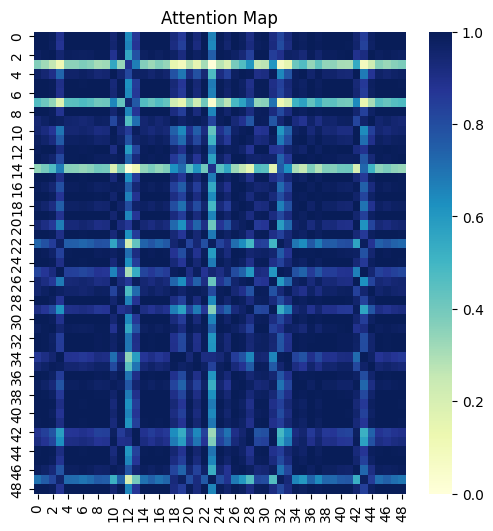

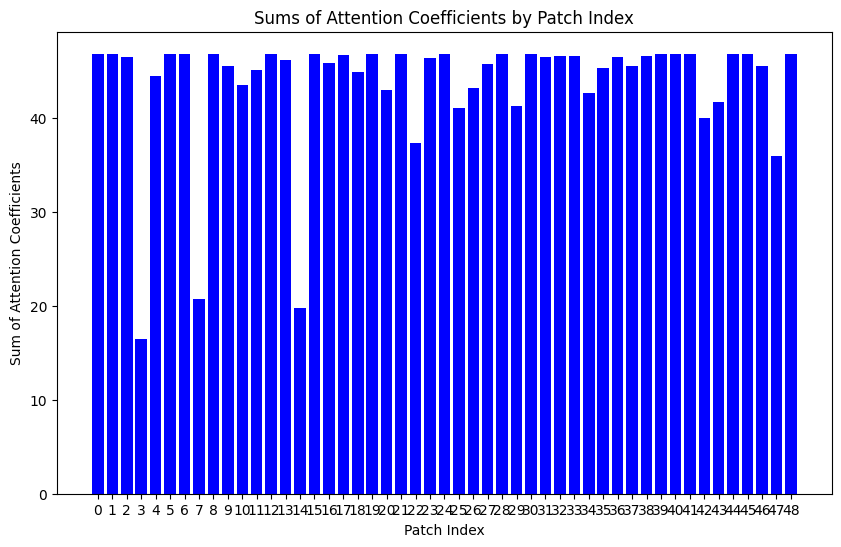

Predicted class for the sample: 0.0
Row sums: [46.867233 46.817974 46.580578 16.462336 44.548122 46.887268 46.87299
 20.73679  46.834915 45.529034 43.541626 45.171738 46.8384   46.22815
 19.782854 46.886955 45.851425 46.779488 44.949112 46.841022 43.02877
 46.88713  37.355137 46.439392 46.886948 41.10578  43.230934 45.754997
 46.806538 41.325787 46.85933  46.577248 46.593872 46.63242  42.683
 45.323174 46.59052  45.581043 46.692917 46.887302 46.81531  46.883896
 40.088726 41.699417 46.8745   46.834038 45.544563 35.961796 46.840294]


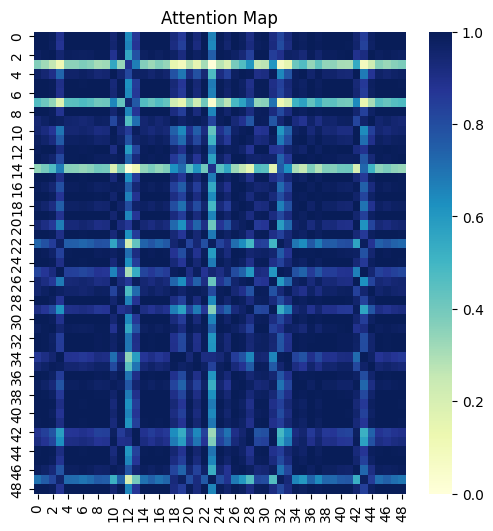

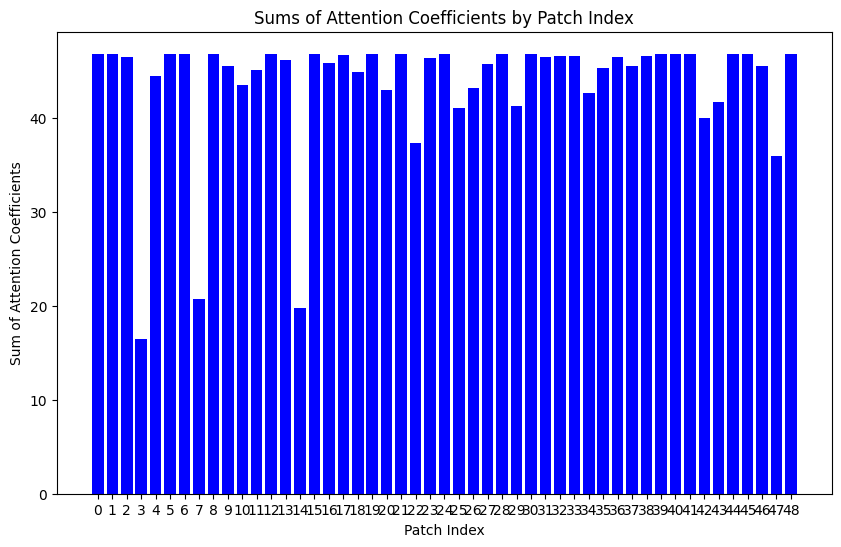

Extracted attention values: tensor([[[0.9986, 0.9994, 0.9890,  ..., 0.9999, 0.9992, 0.9977],
         [0.9996, 0.9982, 0.9850,  ..., 0.9992, 0.9999, 0.9991],
         [0.9809, 0.9942, 1.0000,  ..., 0.9919, 0.9834, 0.9780],
         ...,
         [0.9878, 0.9704, 0.9376,  ..., 0.9750, 0.9857, 0.9900],
         [0.7253, 0.7756, 0.8358,  ..., 0.7645, 0.7330, 0.7168],
         [0.9993, 0.9987, 0.9866,  ..., 0.9995, 0.9997, 0.9986]]])


In [25]:
# Select a single sample from the test set
single_sample = torch.tensor(X_test[1:2].astype(np.float32))  # Select one sample

# Make a prediction for the single sample
# Get the attention values for a single sample
with torch.no_grad():
    prediction = attention_model(single_sample).squeeze()
    predicted_class = (torch.round(prediction)).item()
    print(f"Predicted class for the sample: {predicted_class}")

    _ = attention_model(single_sample)  # Forward pass to calculate attention
    attention_values = attention_model.attention_values  # Extracted attention values
    print(f"Extracted attention values: {attention_values}")

-----------------------------------------

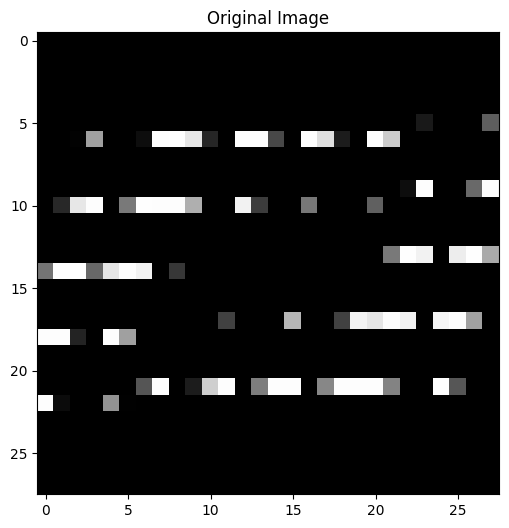

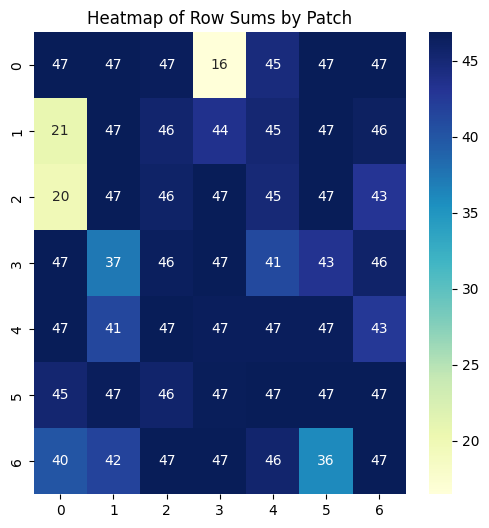

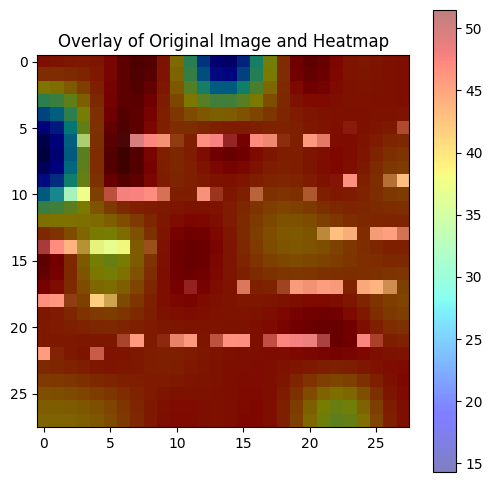

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_sample_and_heatmap(sample, row_sums, patch_shape=(7, 7)):
    """
    sample: The original image (2D numpy array)
    row_sums: The sums corresponding to each patch
    patch_shape: Shape of the patch grid (e.g., (2, 2))
    """
    # 1. Plot the original sample image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title("Original Image")
    plt.show()

    # 2. Create the heatmap using the row sums
    heatmap_values = np.array(row_sums).reshape(patch_shape)

    plt.figure(figsize=(6, 6))
    sns.heatmap(heatmap_values, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Heatmap of Row Sums by Patch")
    plt.show()

    # 3. Resize the heatmap to match the sample size
    from scipy.ndimage import zoom
    resized_heatmap = zoom(heatmap_values, (sample.shape[0] / patch_shape[0], sample.shape[1] / patch_shape[1]))

    # Overlay the heatmap on the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.imshow(resized_heatmap, cmap='jet', alpha=0.5, interpolation='none')
    plt.colorbar()
    plt.title("Overlay of Original Image and Heatmap")
    plt.show()

# Example usage
# Select a single sample from the test set
single_sample = torch.tensor(X_test[1:2].astype(np.float32))  # Select one sample

# Reshape the single sample back to its 2D form for visualization (assuming it's 8x8 based on CIFAR-10 patching)
original_image = single_sample.squeeze().reshape(28, 28).numpy()  # Reshape to 2D

# Example row sums based on output
row_sums =[46.867233, 46.817974, 46.580578, 16.462336, 44.548122, 46.887268, 46.87299, 
           20.73679, 46.834915, 45.529034, 43.541626, 45.171738, 46.8384, 46.22815, 
           19.782854, 46.886955, 45.851425, 46.779488, 44.949112, 46.841022, 43.02877, 
           46.88713, 37.355137, 46.439392, 46.886948, 41.10578, 43.230934, 45.754997, 
           46.806538, 41.325787, 46.85933, 46.577248, 46.593872, 46.63242, 42.683, 
           45.323174, 46.59052, 45.581043, 46.692917, 46.887302, 46.81531, 46.883896, 
           40.088726, 41.699417, 46.8745, 46.834038, 45.544563, 35.961796, 46.840294]


# Visualize the sample and the heatmap
visualize_sample_and_heatmap(original_image, row_sums, patch_shape=(7, 7))


Row sums: [46.694305 46.65163  46.373016 16.534037 44.45794  46.70719  46.698887
 20.819025 46.666695 45.380383 46.4604   42.062725 46.64675  46.09326
 19.461601 46.70753  46.682045 44.410103 45.011627 46.67205  42.966927
 46.707413 37.066326 46.23165  46.282097 42.78593  43.16566  45.52548
 46.641342 41.289845 46.67494  37.299587 43.061783 46.47959  42.41937
 45.08637  46.439976 40.27127  42.442505 46.707325 46.649246 46.700466
 40.06902  41.658188 46.688282 46.66592  45.430866 35.66883  46.671413]


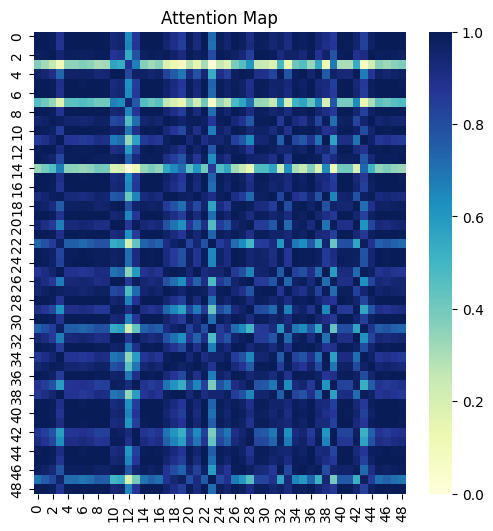

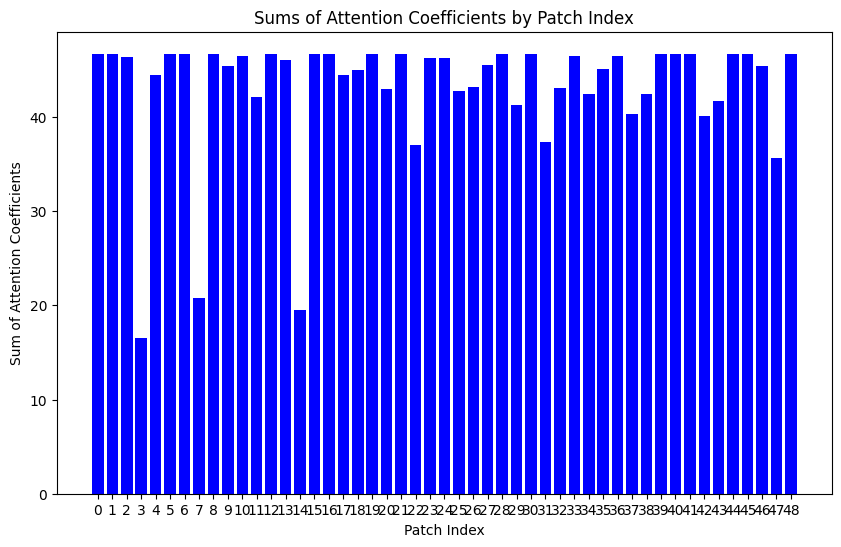

Predicted class for the sample: 0.0
Row sums: [46.694305 46.65163  46.373016 16.534037 44.45794  46.70719  46.698887
 20.819025 46.666695 45.380383 46.4604   42.062725 46.64675  46.09326
 19.461601 46.70753  46.682045 44.410103 45.011627 46.67205  42.966927
 46.707413 37.066326 46.23165  46.282097 42.78593  43.16566  45.52548
 46.641342 41.289845 46.67494  37.299587 43.061783 46.47959  42.41937
 45.08637  46.439976 40.27127  42.442505 46.707325 46.649246 46.700466
 40.06902  41.658188 46.688282 46.66592  45.430866 35.66883  46.671413]


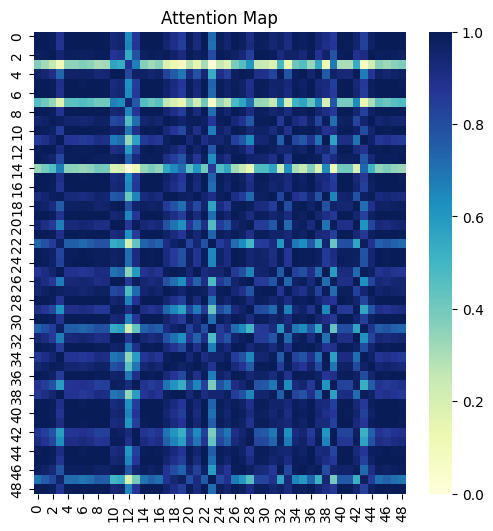

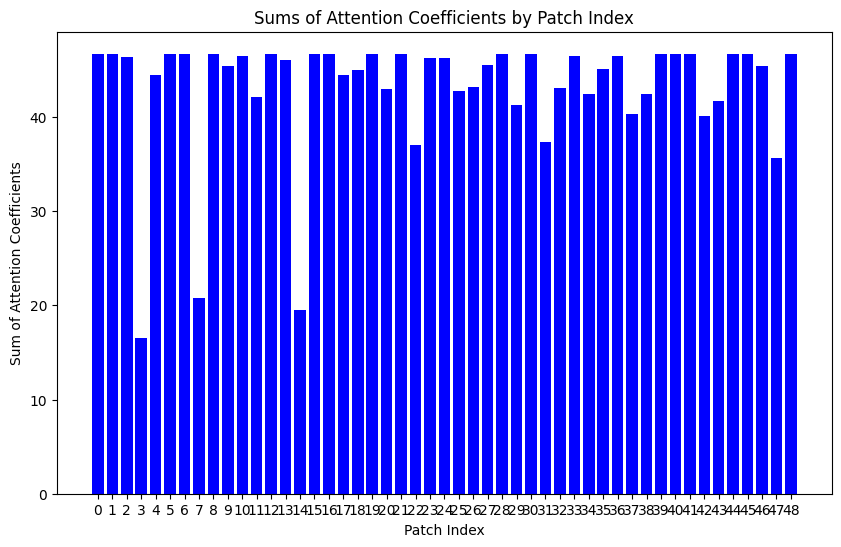

Extracted attention values: tensor([[[0.9986, 0.9994, 0.9890,  ..., 0.9999, 0.9992, 0.9977],
         [0.9996, 0.9982, 0.9850,  ..., 0.9992, 0.9999, 0.9991],
         [0.9809, 0.9942, 1.0000,  ..., 0.9919, 0.9834, 0.9780],
         ...,
         [0.9878, 0.9704, 0.9376,  ..., 0.9750, 0.9857, 0.9900],
         [0.7253, 0.7756, 0.8358,  ..., 0.7645, 0.7330, 0.7168],
         [0.9993, 0.9987, 0.9866,  ..., 0.9995, 0.9997, 0.9986]]])


In [27]:
# Select a single sample from the test set
single_sample = torch.tensor(X_test[20:21].astype(np.float32))  # Select one sample

# Make a prediction for the single sample
# Get the attention values for a single sample
with torch.no_grad():
    prediction = attention_model(single_sample).squeeze()
    predicted_class = (torch.round(prediction)).item()
    print(f"Predicted class for the sample: {predicted_class}")

    _ = attention_model(single_sample)  # Forward pass to calculate attention
    attention_values = attention_model.attention_values  # Extracted attention values
    print(f"Extracted attention values: {attention_values}")

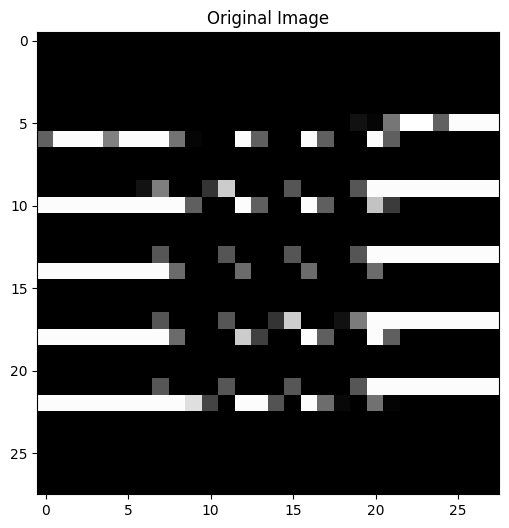

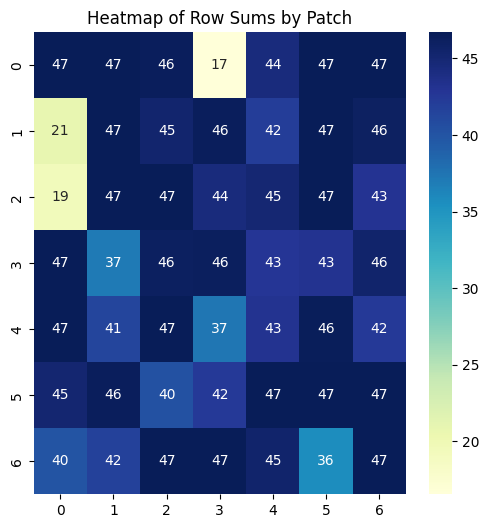

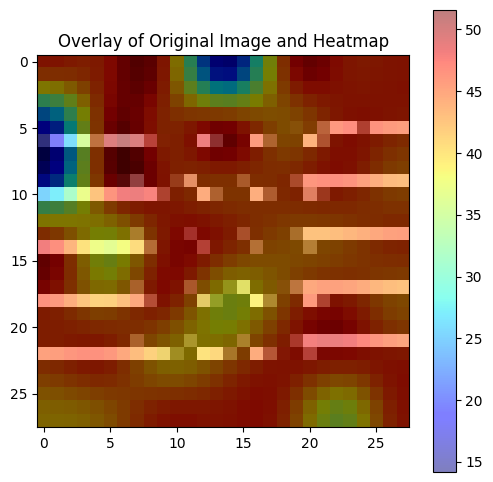

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_sample_and_heatmap(sample, row_sums, patch_shape=(7, 7)):
    """
    sample: The original image (2D numpy array)
    row_sums: The sums corresponding to each patch
    patch_shape: Shape of the patch grid (e.g., (2, 2))
    """
    # 1. Plot the original sample image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title("Original Image")
    plt.show()

    # 2. Create the heatmap using the row sums
    heatmap_values = np.array(row_sums).reshape(patch_shape)

    plt.figure(figsize=(6, 6))
    sns.heatmap(heatmap_values, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Heatmap of Row Sums by Patch")
    plt.show()

    # 3. Resize the heatmap to match the sample size
    from scipy.ndimage import zoom
    resized_heatmap = zoom(heatmap_values, (sample.shape[0] / patch_shape[0], sample.shape[1] / patch_shape[1]))

    # Overlay the heatmap on the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.imshow(resized_heatmap, cmap='jet', alpha=0.5, interpolation='none')
    plt.colorbar()
    plt.title("Overlay of Original Image and Heatmap")
    plt.show()

# Example usage
# Select a single sample from the test set
single_sample = torch.tensor(X_test[20:21].astype(np.float32))  # Select one sample

# Reshape the single sample back to its 2D form for visualization (assuming it's 8x8 based on CIFAR-10 patching)
original_image = single_sample.squeeze().reshape(28, 28).numpy()  # Reshape to 2D

# Example row sums based on output
row_sums =[46.694305, 46.65163, 46.373016, 16.534037, 44.45794, 46.70719, 46.698887, 20.819025, 46.666695, 45.380383, 46.4604, 42.062725, 46.64675, 46.09326, 19.461601, 46.70753, 46.682045, 44.410103, 45.011627, 46.67205, 42.966927, 46.707413, 37.066326, 46.23165, 46.282097, 42.78593, 43.16566, 45.52548, 46.641342, 41.289845, 46.67494, 37.299587, 43.061783, 46.47959, 42.41937, 45.08637, 46.439976, 40.27127, 42.442505, 46.707325, 46.649246, 46.700466, 40.06902, 41.658188, 46.688282, 46.66592, 45.430866, 35.66883, 46.671413]



# Visualize the sample and the heatmap
visualize_sample_and_heatmap(original_image*255, row_sums, patch_shape=(7, 7))


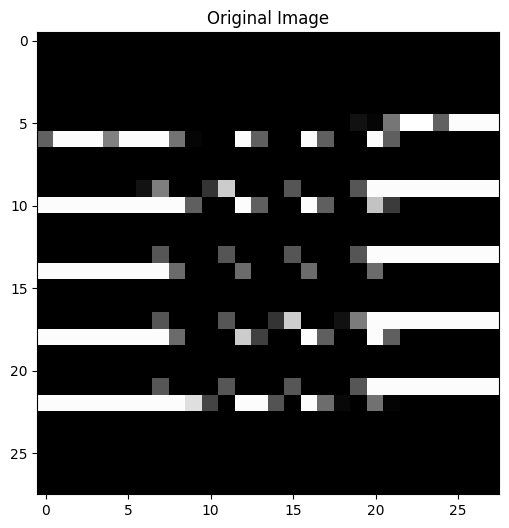

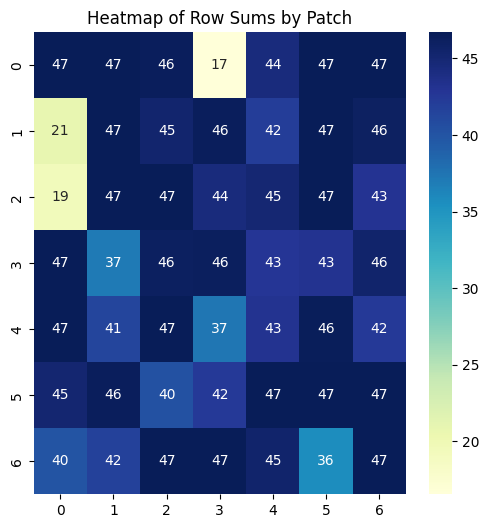

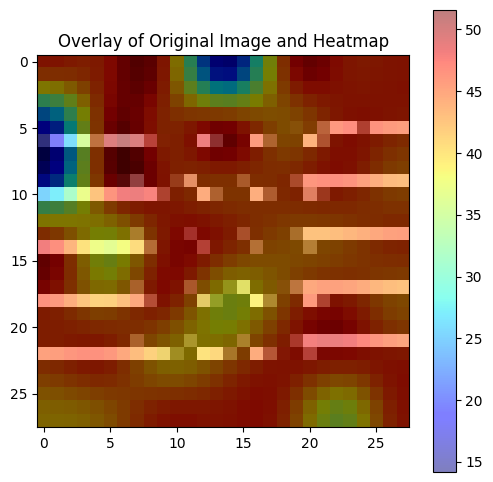

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_sample_and_heatmap(sample, row_sums, patch_shape=(7, 7)):
    """
    sample: The original image (2D numpy array)
    row_sums: The sums corresponding to each patch
    patch_shape: Shape of the patch grid (e.g., (2, 2))
    """
    # 1. Plot the original sample image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title("Original Image")
    plt.show()

    # 2. Create the heatmap using the row sums
    heatmap_values = np.array(row_sums).reshape(patch_shape)

    plt.figure(figsize=(6, 6))
    sns.heatmap(heatmap_values, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Heatmap of Row Sums by Patch")
    plt.show()

    # 3. Resize the heatmap to match the sample size
    from scipy.ndimage import zoom
    resized_heatmap = zoom(heatmap_values, (sample.shape[0] / patch_shape[0], sample.shape[1] / patch_shape[1]))

    # Overlay the heatmap on the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.imshow(resized_heatmap, cmap='jet', alpha=0.5, interpolation='none')
    plt.colorbar()
    plt.title("Overlay of Original Image and Heatmap")
    plt.show()

# Example usage
# Select a single sample from the test set
single_sample = torch.tensor(X_test[20:21].astype(np.float32))  # Select one sample

# Reshape the single sample back to its 2D form for visualization (assuming it's 8x8 based on CIFAR-10 patching)
original_image = single_sample.squeeze().reshape(28, 28).numpy()  # Reshape to 2D

# Example row sums based on output
row_sums =[46.694305, 46.65163, 46.373016, 16.534037, 44.45794, 46.70719, 46.698887, 20.819025, 46.666695, 45.380383, 46.4604, 42.062725, 46.64675, 46.09326, 19.461601, 46.70753, 46.682045, 44.410103, 45.011627, 46.67205, 42.966927, 46.707413, 37.066326, 46.23165, 46.282097, 42.78593, 43.16566, 45.52548, 46.641342, 41.289845, 46.67494, 37.299587, 43.061783, 46.47959, 42.41937, 45.08637, 46.439976, 40.27127, 42.442505, 46.707325, 46.649246, 46.700466, 40.06902, 41.658188, 46.688282, 46.66592, 45.430866, 35.66883, 46.671413]



# Visualize the sample and the heatmap
visualize_sample_and_heatmap(original_image*255, row_sums, patch_shape=(7, 7))


Row sums: [46.75529  46.728363 46.34596  16.994888 44.69605  46.750732 46.757027
 21.292423 46.738968 45.196667 45.713497 36.459175 46.661247 46.241096
 19.30281  46.75265  45.90325  46.686367 44.51791  46.742542 43.256268
 46.75182  36.81773  46.425476 46.158432 42.54304  43.449047 45.43801
 46.72078  41.62219  46.7285   46.366444 46.556015 46.587677 42.233482
 44.978157 46.55324  40.51692  46.757736 46.749313 46.726627 46.735695
 40.426502 41.98204  46.71651  46.56876  45.622993 35.41419  46.742126]


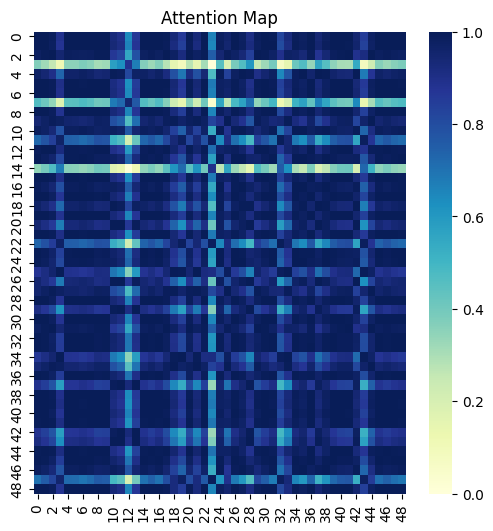

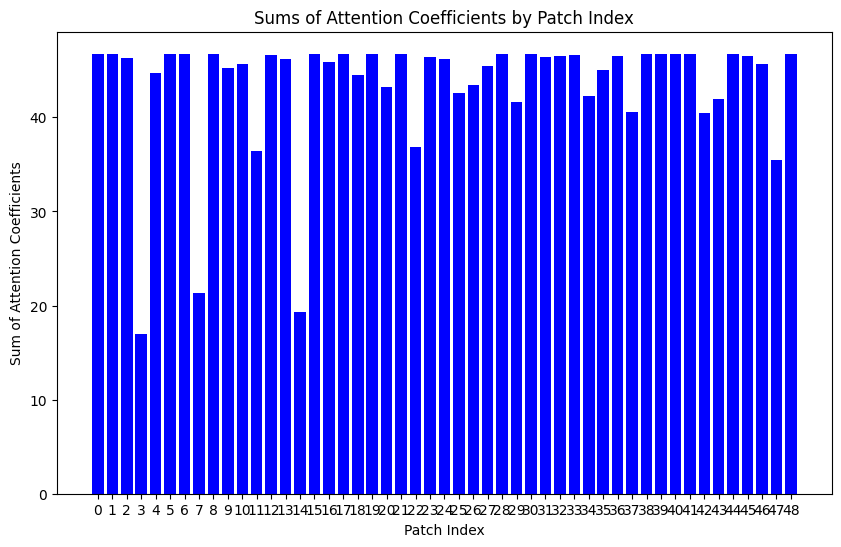

Predicted class for the sample: 0.0
Row sums: [46.75529  46.728363 46.34596  16.994888 44.69605  46.750732 46.757027
 21.292423 46.738968 45.196667 45.713497 36.459175 46.661247 46.241096
 19.30281  46.75265  45.90325  46.686367 44.51791  46.742542 43.256268
 46.75182  36.81773  46.425476 46.158432 42.54304  43.449047 45.43801
 46.72078  41.62219  46.7285   46.366444 46.556015 46.587677 42.233482
 44.978157 46.55324  40.51692  46.757736 46.749313 46.726627 46.735695
 40.426502 41.98204  46.71651  46.56876  45.622993 35.41419  46.742126]


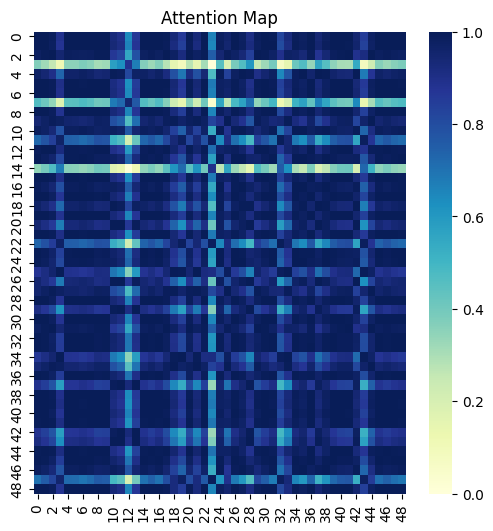

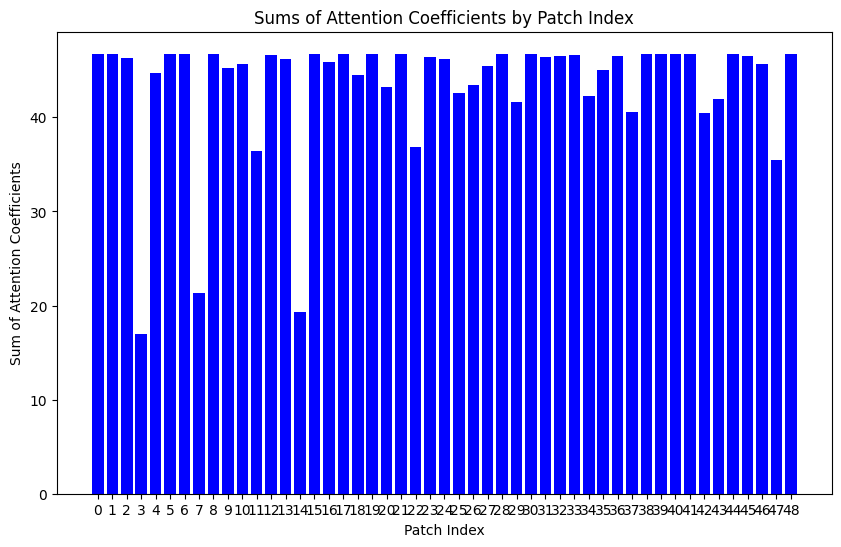

Extracted attention values: tensor([[[0.9986, 0.9994, 0.9890,  ..., 0.9999, 0.9992, 0.9977],
         [0.9996, 0.9982, 0.9850,  ..., 0.9992, 0.9999, 0.9991],
         [0.9809, 0.9942, 1.0000,  ..., 0.9919, 0.9834, 0.9780],
         ...,
         [0.9878, 0.9704, 0.9376,  ..., 0.9750, 0.9857, 0.9900],
         [0.7253, 0.7756, 0.8358,  ..., 0.7645, 0.7330, 0.7168],
         [0.9993, 0.9987, 0.9866,  ..., 0.9995, 0.9997, 0.9986]]])


In [29]:
# Select a single sample from the test set
single_sample = torch.tensor(X_test[15:16].astype(np.float32))  # Select one sample

# Make a prediction for the single sample
# Get the attention values for a single sample
with torch.no_grad():
    prediction = attention_model(single_sample).squeeze()
    predicted_class = (torch.round(prediction)).item()
    print(f"Predicted class for the sample: {predicted_class}")

    _ = attention_model(single_sample)  # Forward pass to calculate attention
    attention_values = attention_model.attention_values  # Extracted attention values
    print(f"Extracted attention values: {attention_values}")

Row sums: [46.99568  46.945675 46.708828 16.399942 44.654503 47.016266 47.001553
 20.689674 46.96286  45.65099  42.526474 46.389076 46.96769  46.349625
 19.767338 47.015923 45.969364 46.906597 44.789043 46.96905  43.122356
 47.016113 37.42488  46.56294  45.508087 44.928642 43.326183 45.87838
 46.93409  41.405605 46.98992  45.731926 46.719006 46.757965 42.786407
 45.443813 46.71562  46.808575 46.840958 47.016327 46.94298  47.013058
 40.158867 41.78221  47.003757 46.961964 45.659706 36.02321  46.968307]


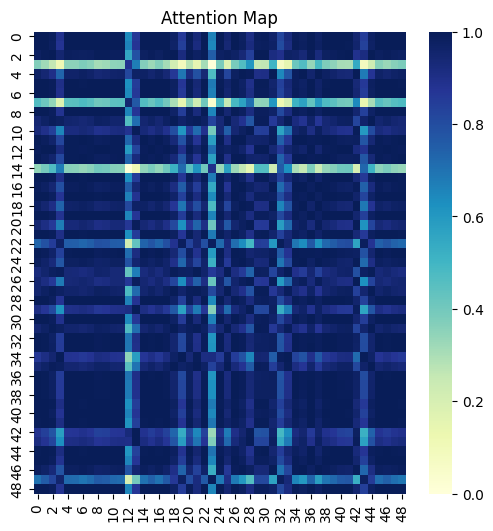

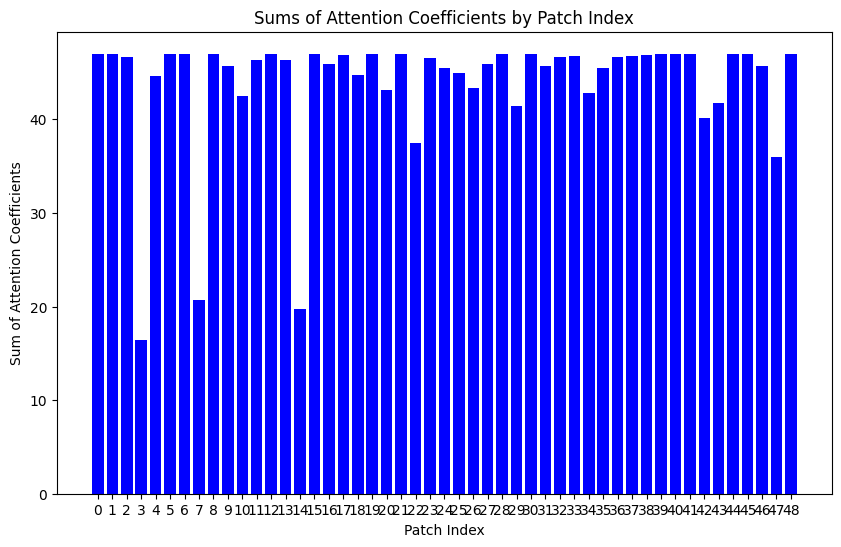

Predicted class for sample 0: 0.0
Row sums: [46.867233 46.817974 46.580578 16.462336 44.548122 46.887268 46.87299
 20.73679  46.834915 45.529034 43.541626 45.171738 46.8384   46.22815
 19.782854 46.886955 45.851425 46.779488 44.949112 46.841022 43.02877
 46.88713  37.355137 46.439392 46.886948 41.10578  43.230934 45.754997
 46.806538 41.325787 46.85933  46.577248 46.593872 46.63242  42.683
 45.323174 46.59052  45.581043 46.692917 46.887302 46.81531  46.883896
 40.088726 41.699417 46.8745   46.834038 45.544563 35.961796 46.840294]


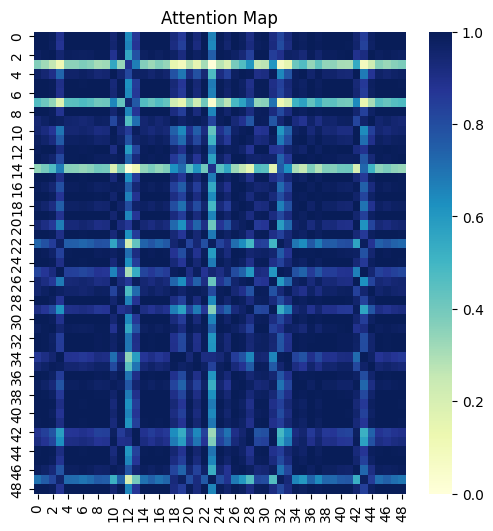

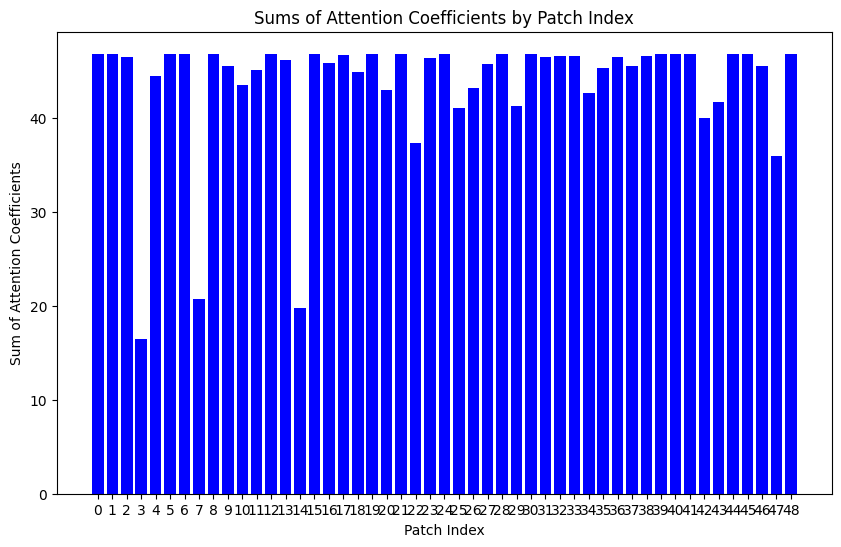

Predicted class for sample 1: 0.0
Row sums: [46.87219  46.814487 46.633175 16.280586 44.45901  46.901596 46.879475
 20.540573 46.83382  45.62137  46.703632 40.75571  46.868412 46.186745
 19.968014 46.900436 45.796024 46.869587 46.086937 46.840878 42.912792
 46.900997 37.541245 46.407787 46.78838  44.34452  43.11807  45.840958
 46.801598 41.18745  46.832382 44.98478  46.571075 46.612175 42.82596
 45.420784 46.567513 43.84021  36.443127 46.902187 46.811478 46.902702
 39.937443 41.565475 46.897087 46.83281  45.479694 36.15405  46.840034]


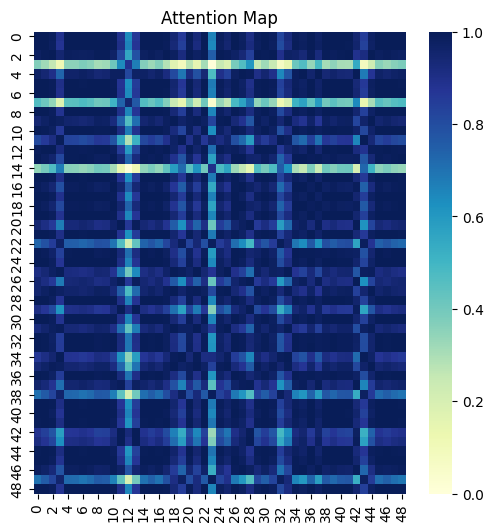

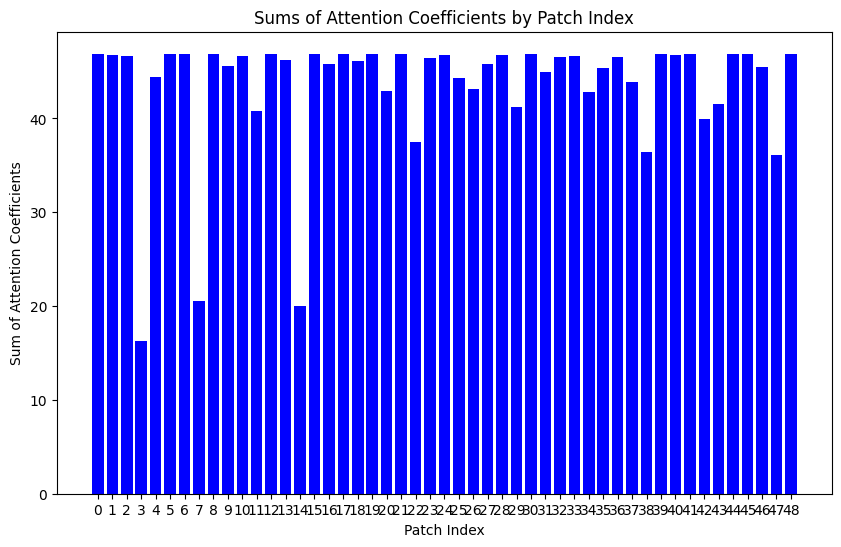

Predicted class for sample 2: 0.0
Row sums: [46.43567  46.381317 46.2088   17.212048 44.152992 46.46324  46.442516
 21.314653 46.39954  45.252724 40.20867  46.460308 46.43152  45.7884
 26.225792 45.9784   44.901154 44.292175 43.003437 46.40619  42.687057
 45.413254 42.203873 45.997326 45.664066 45.654293 42.881783 45.46012
 46.369167 41.049232 46.381542 46.429447 46.25379  46.190407 42.613796
 45.063293 46.148224 39.950996 46.21383  45.559925 46.37848  46.464176
 39.861423 41.40826  46.458786 46.398586 41.07086  36.314777 46.405396]


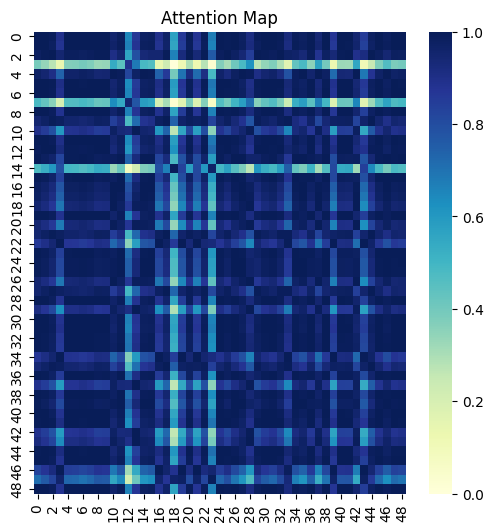

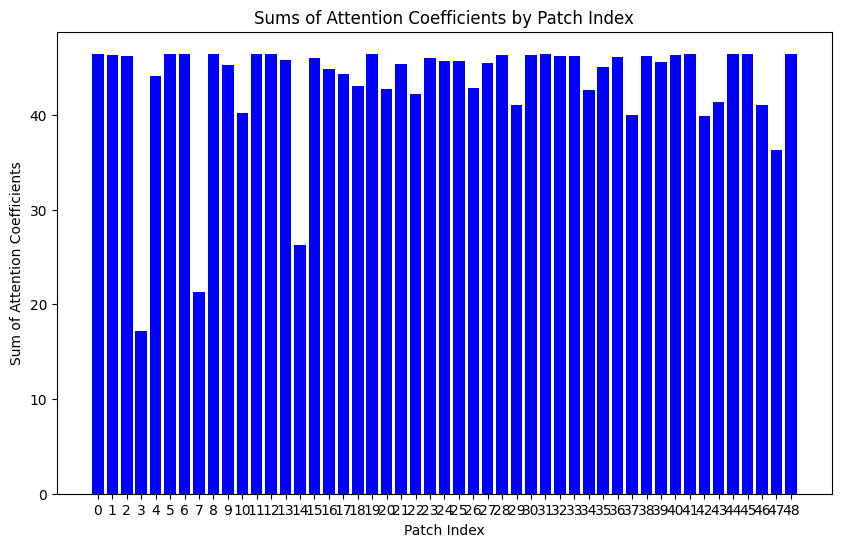

Predicted class for sample 3: 1.0
Row sums: [46.543667 46.482677 46.333714 16.314217 44.126797 46.577377 46.55161
 20.523546 46.502888 45.36091  45.747513 46.356396 46.552917 45.847076
 20.113602 46.575798 45.4564   46.018253 44.33102  46.510307 42.59508
 46.57655  37.465332 46.069046 46.16717  41.00691  42.798214 45.573227
 46.46928  40.889355 46.540768 43.698837 46.233837 46.275486 42.64094
 45.166676 46.23023  45.19971  44.63928  43.158623 46.47955  46.58078
 39.65488  41.26287  46.57722  46.501823 45.141083 36.10271  46.509415]


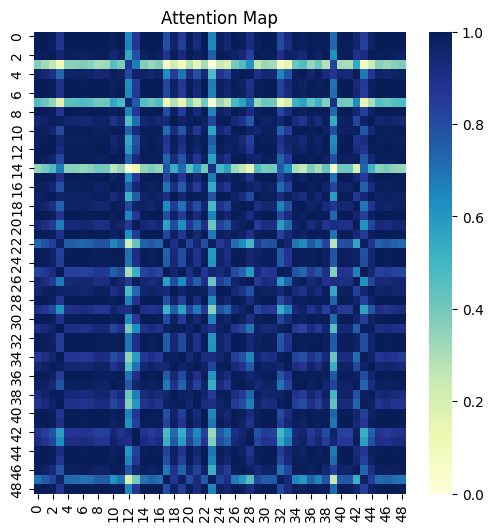

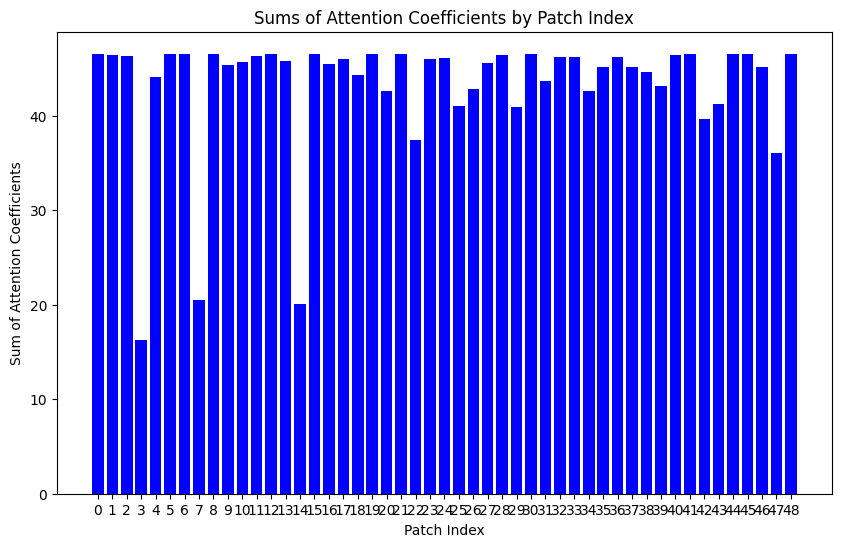

Predicted class for sample 4: 0.0
Row sums: [47.100735 47.008778 47.049397 15.343444 44.283916 47.167812 47.114193
 19.597351 47.03785  46.18745  40.581764 45.756855 41.173088 46.222954
 20.817204 47.16324  45.77183  47.06851  47.175865 47.04878  42.610397
 47.16535  38.435043 46.485558 47.15755  46.618073 42.83082  46.38339
 46.98998  40.77235  47.13171  46.796993 46.685787 46.737503 43.5745
 46.00636  46.68133  46.850685 46.802788 47.17063  47.00436  47.18677
 39.453182 41.17314  47.196144 47.036293 45.41397  37.066845 47.047462]


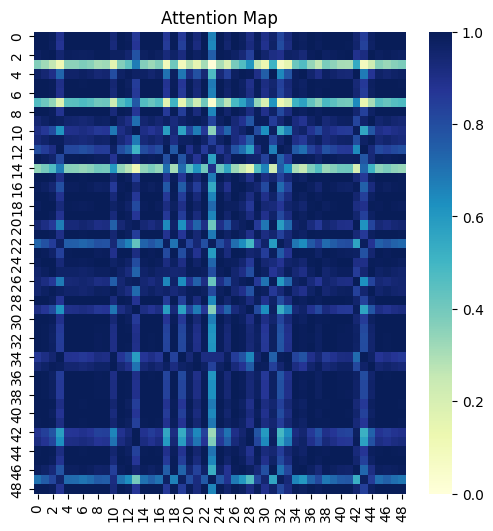

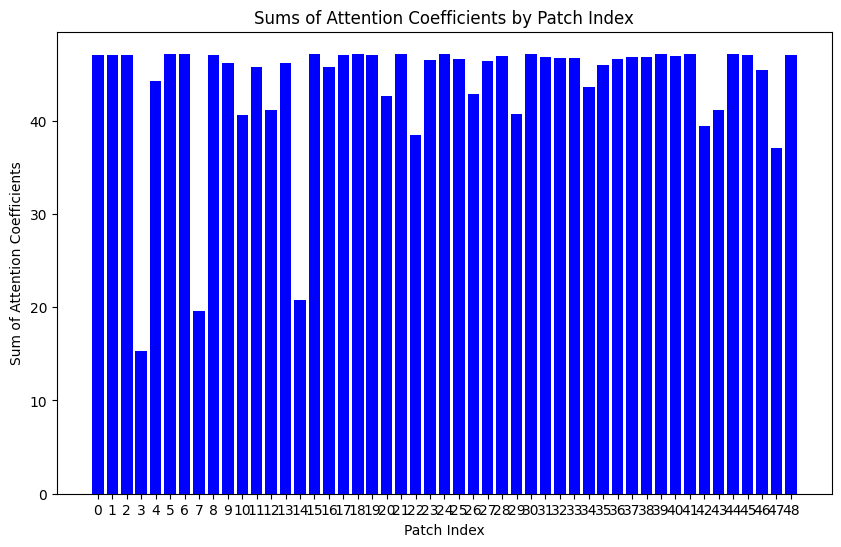

Predicted class for sample 5: 0.0
Row sums: [46.59678  46.544373 46.34449  16.798378 44.29213  46.62132  46.603203
 20.983915 46.56695  42.218777 36.345383 46.616436 46.582405 45.950943
 20.388166 46.618927 39.82856  46.057617 24.926554 46.568565 42.79968
 46.62094  37.46975  46.161465 45.824917 46.58594  42.99806  45.561733
 46.532486 41.129967 46.544598 46.5349   46.616325 46.355103 42.613514
 45.149227 46.312916 40.009617 46.333702 46.62178  46.541607 46.620476
 39.91822  41.496113 46.613415 46.602333 45.273975 36.121307 46.5678  ]


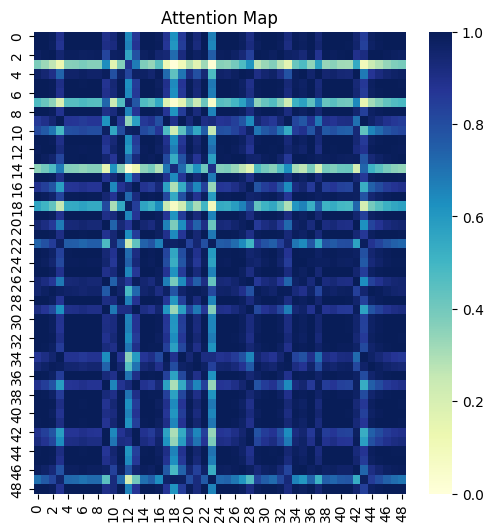

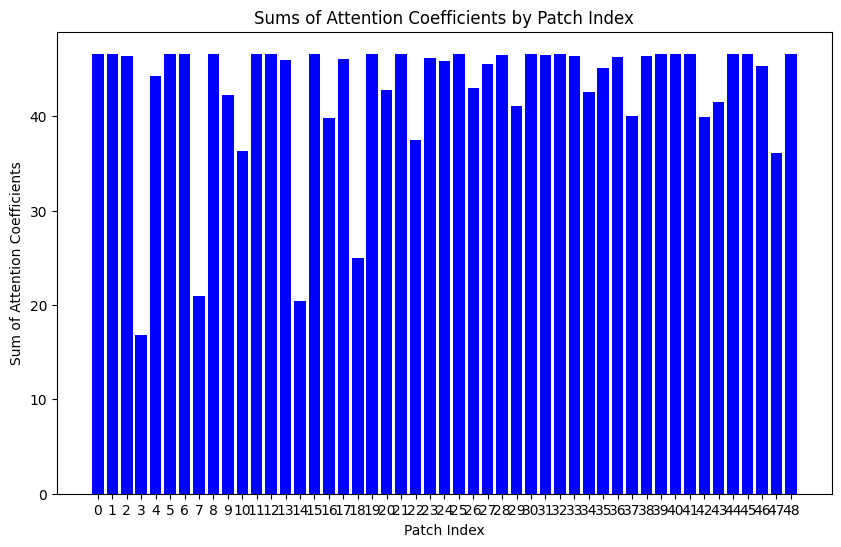

Predicted class for sample 6: 1.0
Row sums: [47.421066 47.390263 46.99212  15.789588 45.191578 47.418274 47.423275
 20.30036  47.402187 45.76661  41.70655  47.42435  30.222809 46.85883
 18.168827 47.38849  45.866993 35.42681  47.17236  46.591587 43.643658
 47.41934  42.048767 46.247105 46.69567  40.01693  43.850716 46.02438
 47.381798 41.890575 47.39042  47.362812 43.82934  47.235485 42.59683
 45.533115 47.197906 40.706615 47.404568 45.944126 47.38832  47.40313
 40.609818 42.276344 47.383377 46.76959  46.1906   35.301678 47.405766]


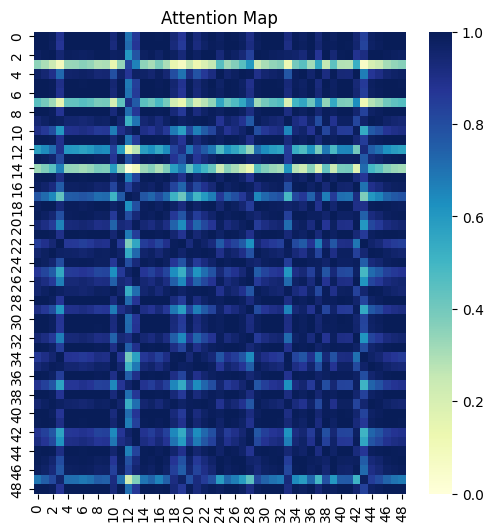

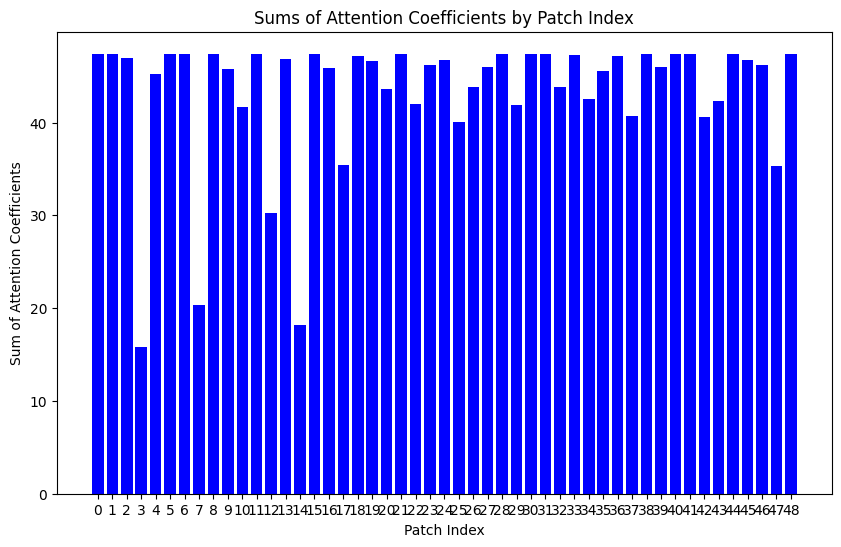

Predicted class for sample 7: 1.0
Row sums: [46.88203  46.81692  46.687847 16.275705 44.39568  46.919846 46.890675
 20.500721 46.838345 45.717876 40.87332  46.59922  38.6873   46.15791
 20.290302 45.247616 46.375072 46.087646 46.00968  46.872524 42.832973
 46.918827 44.593773 46.71581  45.81974  45.580254 43.040024 45.93044
 46.802784 41.0961   46.81719  46.70418  46.761143 46.600395 42.98421
 45.523228 46.259575 43.500618 41.730934 46.3059   46.89011  46.925034
 39.84068  41.476204 46.922897 46.83721  45.43316  36.39456  46.845284]


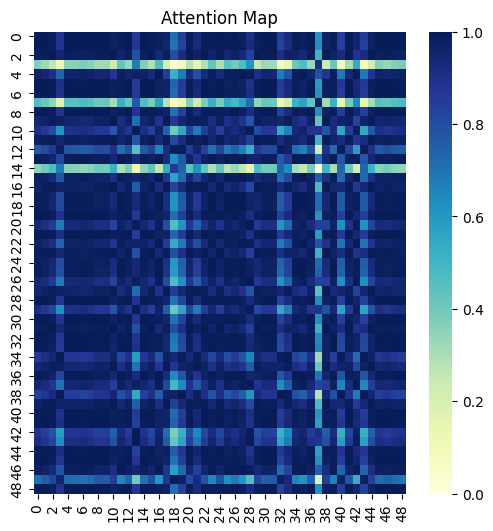

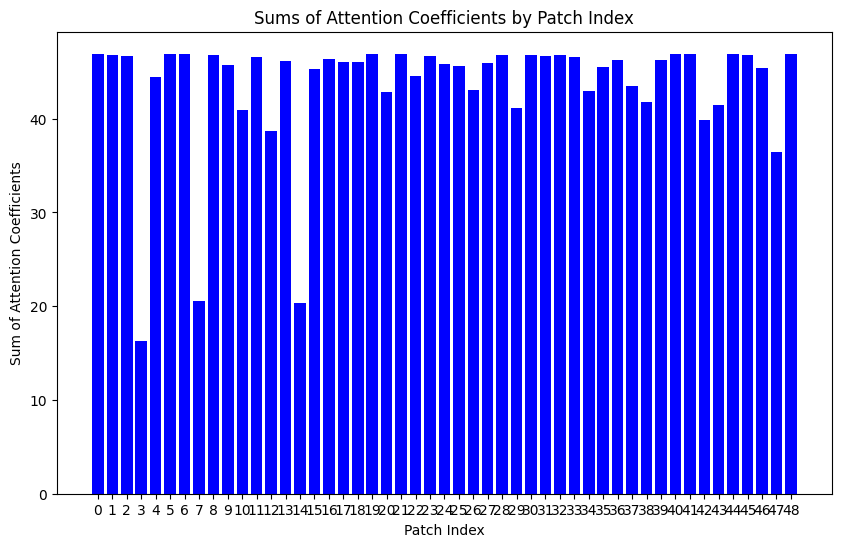

Predicted class for sample 8: 1.0
Row sums: [46.706264 46.682148 46.250103 15.520681 44.58441  46.696693 46.707317
 20.042234 46.692123 45.016262 41.194614 46.704662 46.594322 46.18774
 22.881067 46.13276  42.246403 45.37761  39.05665  46.046307 43.082348
 46.707447 45.06513  43.06575  45.33222  46.61803  45.68273  45.274426
 46.67489  41.374237 46.68228  46.694077 46.523483 45.42491  41.858776
 44.78275  46.50742  40.217705 46.26739  46.70643  46.680496 46.67856
 40.123062 41.750595 46.656403 46.63325  45.548386 34.618996 46.695026]


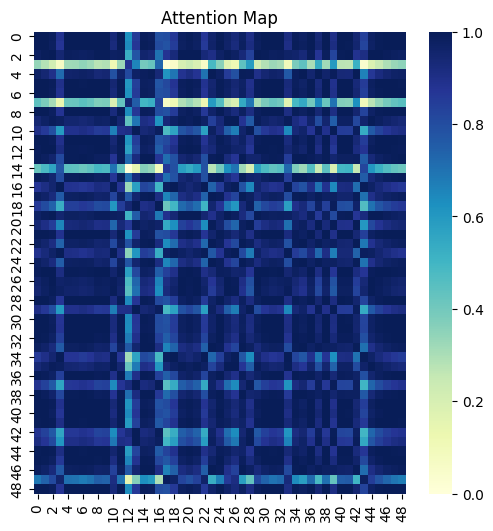

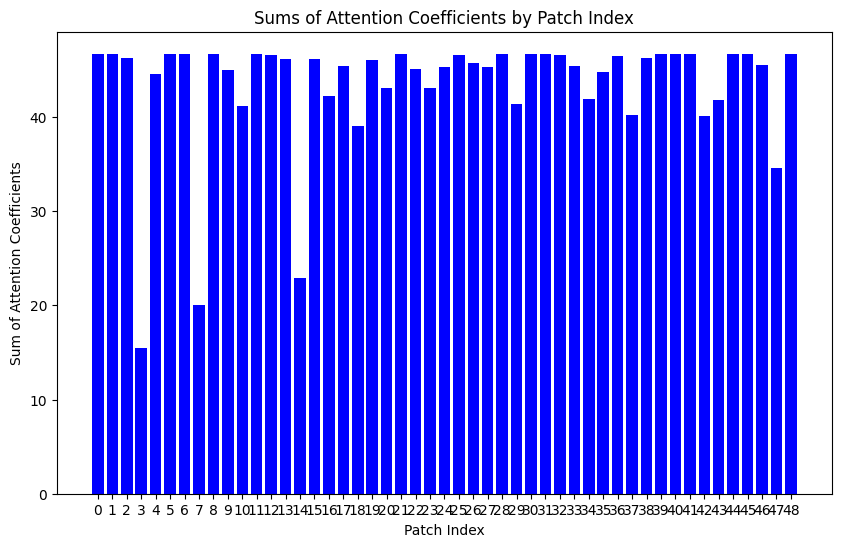

Predicted class for sample 9: 1.0
Row sums: [46.328682 46.29745  45.957264 17.069395 44.265007 46.329758 46.33128
 21.296219 46.309196 44.85841  44.876705 35.49729  46.251663 45.799896
 19.463345 46.331127 45.46217  46.33103  46.2033   46.31325  42.844864
 46.33054  36.712593 45.98548  42.557896 40.42219  43.034748 45.09038
 46.289196 41.237446 46.2976   44.79267  46.15553  46.15036  41.991585
 44.648064 46.11515  40.151707 45.195747 28.241682 46.295547 46.31772
 40.062923 41.591156 46.30122  46.308506 45.18329  35.339417 46.312775]


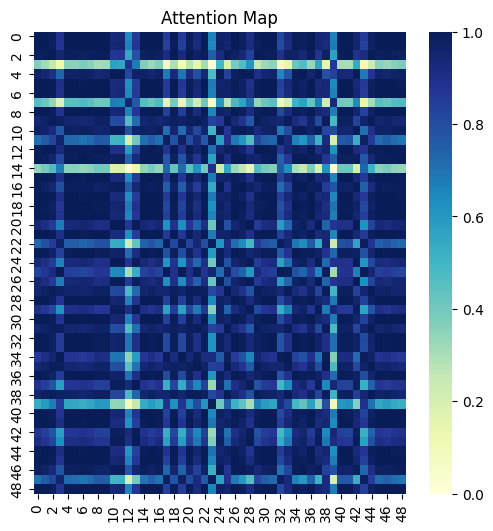

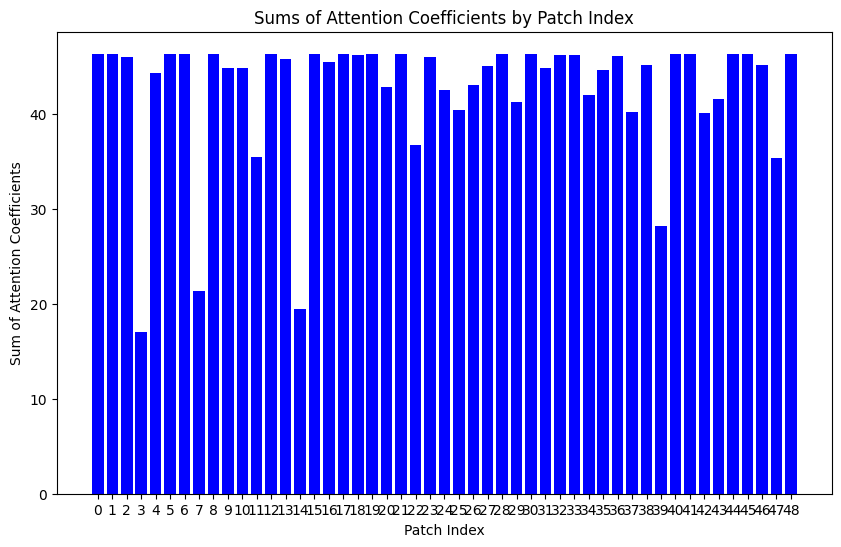

Predicted class for sample 10: 0.0
Row sums: [46.322746 46.335236 45.699978 18.000498 44.737316 46.275    46.3174
 22.304338 46.33463  45.93453  41.35663  45.850815 46.114635 46.03179
 18.152563 45.85904  46.28536  46.18641  46.334682 46.33374  43.451324
 46.278225 35.95122  46.294266 46.038906 45.72174  43.62569  44.650894
 46.33448  41.95525  46.327576 46.230755 42.242455 45.744385 41.21988
 44.143234 46.253307 40.933353 46.334885 33.395565 46.335136 46.239555
 40.84517  42.28708  46.20327  46.31392  45.73777  34.221848 46.33387 ]


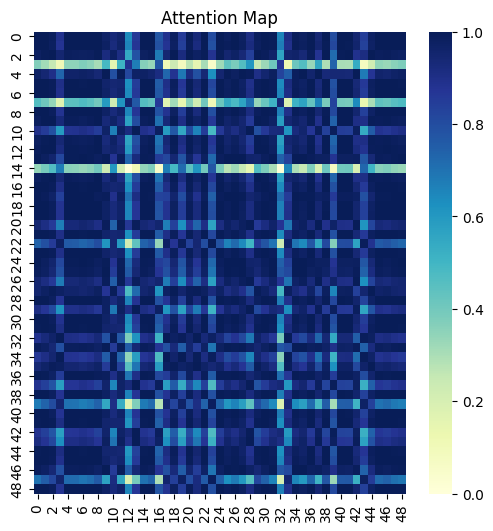

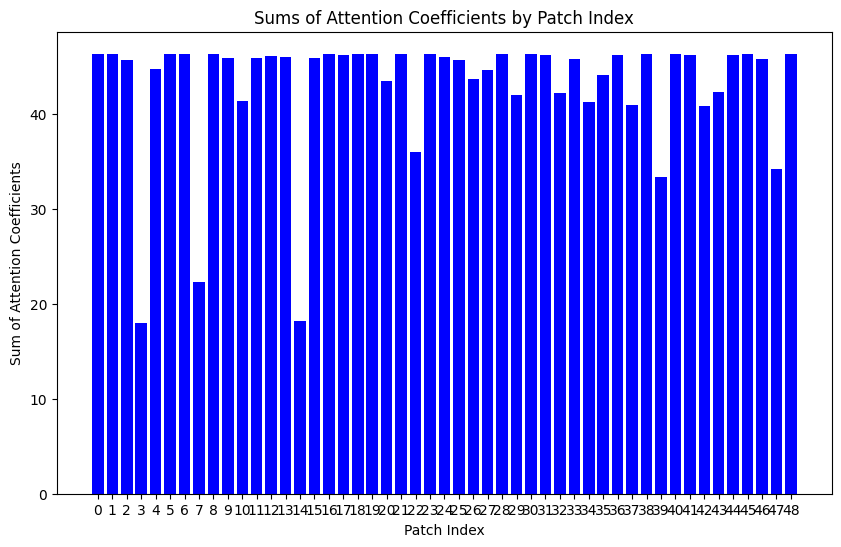

Predicted class for sample 11: 1.0
Row sums: [46.884243 46.85703  46.472237 16.964521 44.808964 46.879738 46.886005
 21.27572  46.867737 45.314537 40.54162  46.161983 46.789715 46.36575
 19.260975 46.81164  41.252995 45.519672 46.825764 46.87135  43.35874
 46.880825 36.875275 46.551594 46.252506 46.71129  43.55289  45.55766
 46.849373 41.713245 46.85717  46.813972 43.482338 46.71512  42.329514
 45.09441  46.6804   40.600494 46.43549  45.81716  46.855274 46.864628
 40.50947  42.075573 46.84533  42.86106  45.742863 35.462204 46.870926]


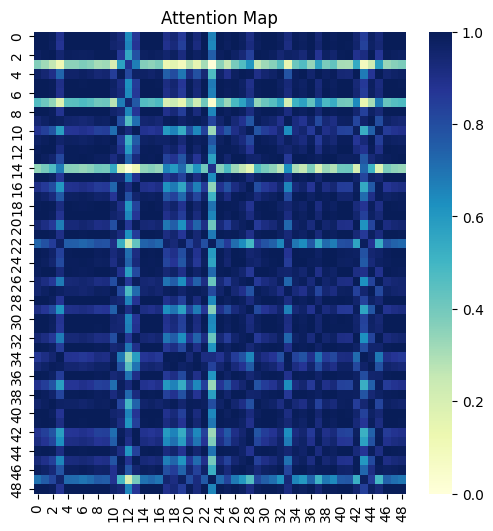

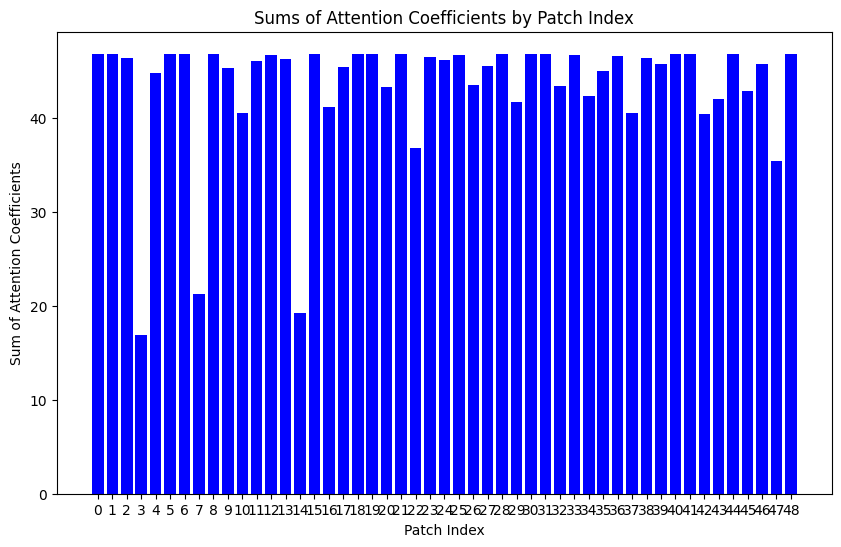

Predicted class for sample 12: 1.0
Row sums: [46.6986   46.640522 46.472237 16.552595 44.31355  46.729073 46.706013
 20.756195 46.65991  45.486122 40.914604 46.476078 39.441345 46.017902
 20.271326 46.697884 41.26439  46.19429  46.26737  46.667    42.79052
 46.7284   37.568386 46.236538 45.96727  45.317078 42.99266  45.700523
 46.627625 41.091854 46.640762 46.67895  46.644882 46.439095 42.750996
 45.290176 46.394783 39.954166 46.713295 46.72975  46.63751  46.730923
 39.861412 41.463993 46.726063 44.907936 45.31981  36.206383 46.66615 ]


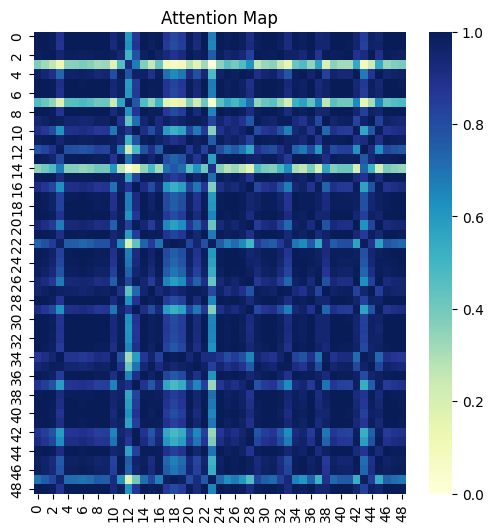

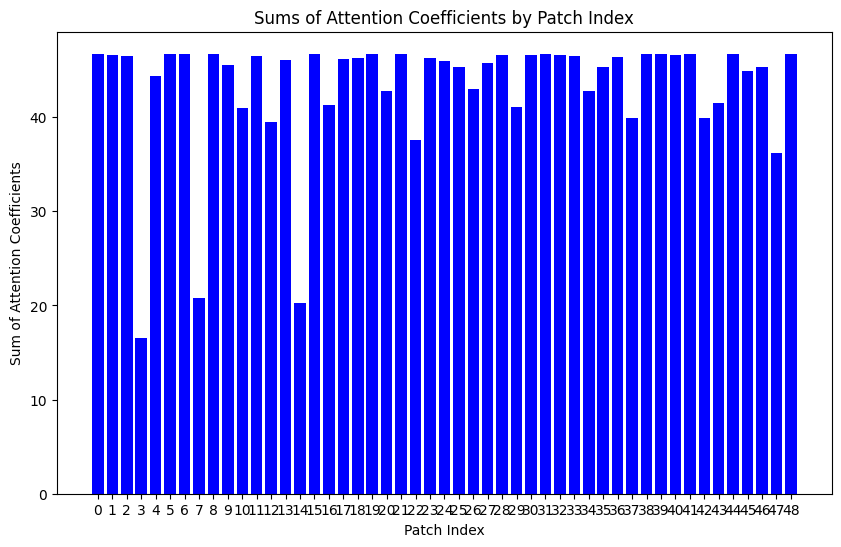

Predicted class for sample 13: 1.0
Row sums: [47.25352  47.191685 47.026157 15.998342 44.755295 47.286793 47.261494
 20.315174 47.212257 46.008305 41.165512 46.80559  37.16632  46.537384
 20.050323 47.28531  46.133327 47.2635   46.150635 47.279335 43.165543
 47.28602  37.824207 46.37693  45.36206  45.689953 43.37644  46.229908
 47.178024 41.394157 47.284542 39.345066 47.011    46.979282 43.179466
 45.805725 46.932705 46.433315 47.27916  47.28759  47.188496 47.289467
 40.111996 41.782093 47.285038 47.211174 45.806816 36.418736 47.218887]


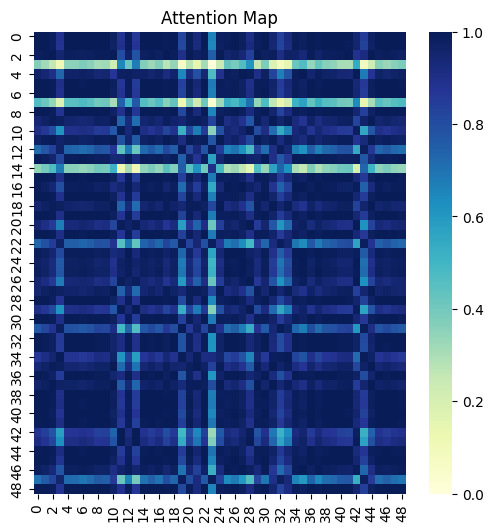

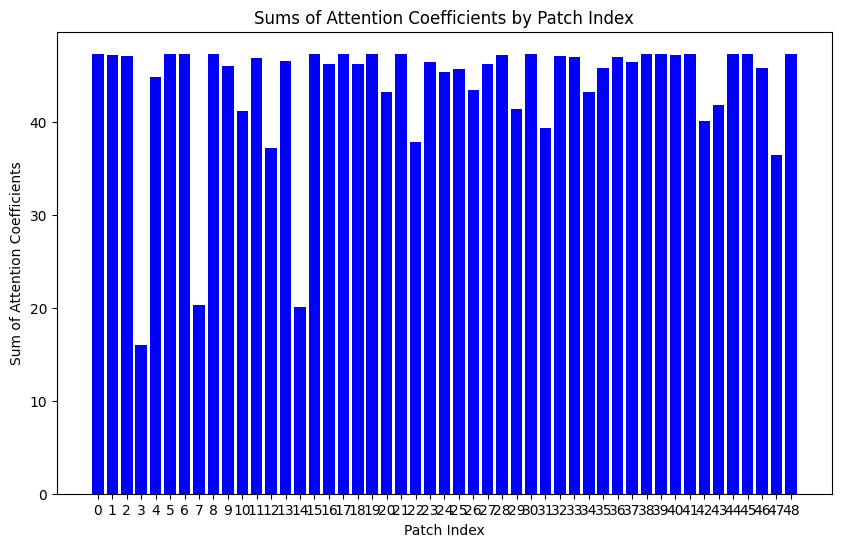

Predicted class for sample 14: 0.0
Row sums: [46.75529  46.728363 46.34596  16.994888 44.69605  46.750732 46.757027
 21.292423 46.738968 45.196667 45.713497 36.459175 46.661247 46.241096
 19.30281  46.75265  45.90325  46.686367 44.51791  46.742542 43.256268
 46.75182  36.81773  46.425476 46.158432 42.54304  43.449047 45.43801
 46.72078  41.62219  46.7285   46.366444 46.556015 46.587677 42.233482
 44.978157 46.55324  40.51692  46.757736 46.749313 46.726627 46.735695
 40.426502 41.98204  46.71651  46.56876  45.622993 35.41419  46.742126]


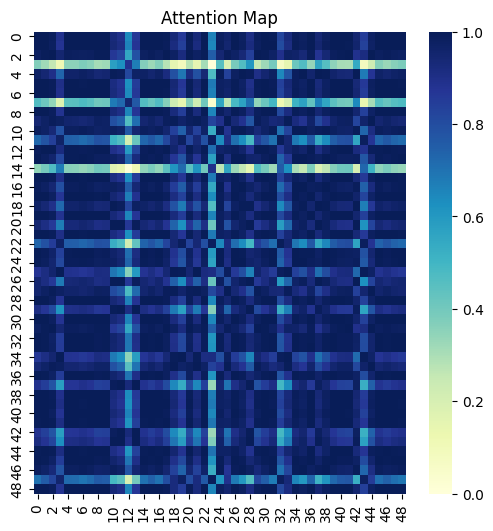

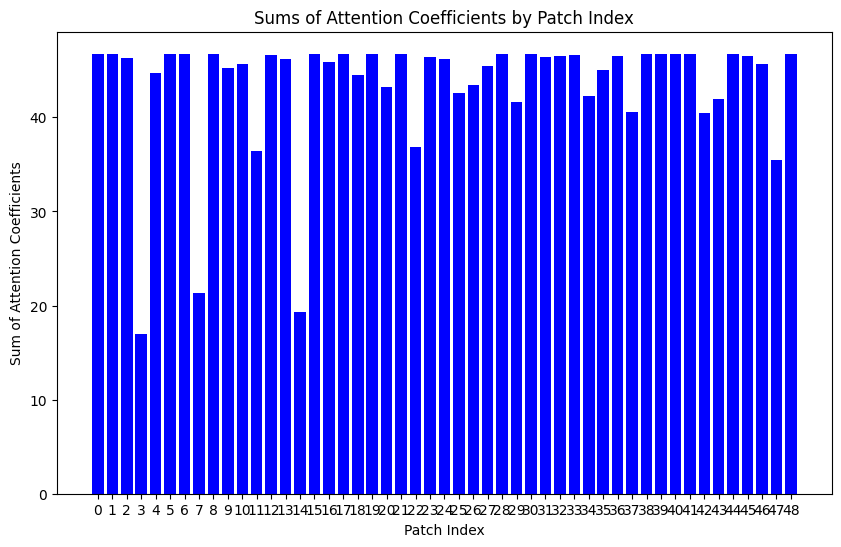

Predicted class for sample 15: 0.0
Row sums: [47.224903 47.135433 47.155094 15.364775 44.422375 47.288948 47.23788
 19.636831 47.163822 46.271454 40.713017 44.287827 47.042496 46.357933
 20.716969 47.284653 45.908684 47.159985 46.22877  47.280838 42.74679
 47.28664  38.427853 46.618843 47.310673 44.044754 42.967625 46.47131
 47.11704  40.904163 47.20728  44.599804 46.81727  46.868412 43.619724
 46.086975 46.812855 47.30634  46.944546 47.291573 47.131115 47.306355
 39.5808   41.3061   46.789963 47.162304 45.551704 37.048317 47.17319 ]


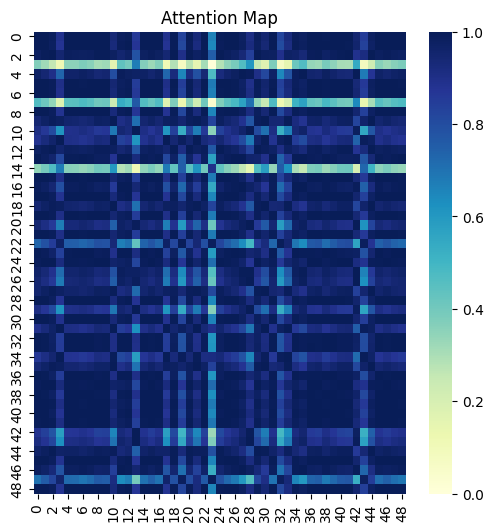

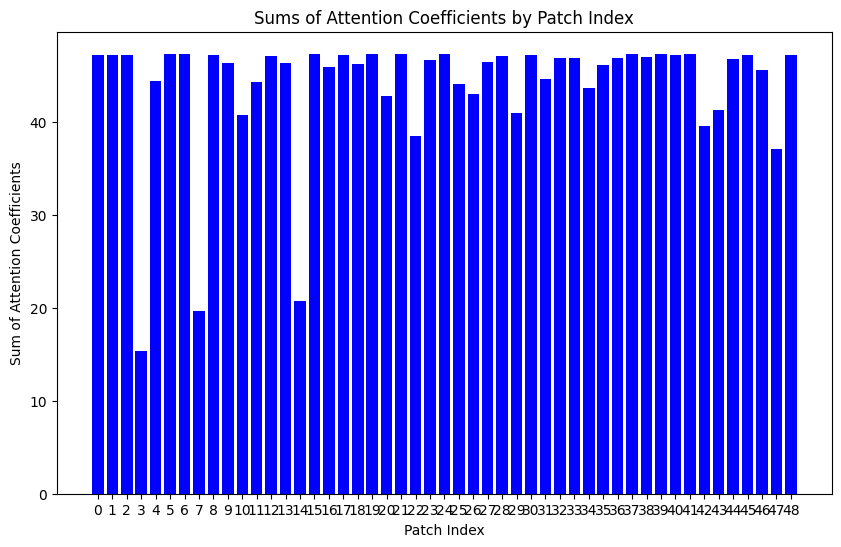

Predicted class for sample 16: 0.0
Row sums: [46.96362  46.948727 46.48362  17.495604 45.03198  46.945526 46.963158
 21.793901 46.955936 45.518925 37.955585 45.76695  39.517853 46.513973
 19.156752 42.004845 39.94086  46.25289  46.814014 45.589603 43.626556
 46.94729  36.71452  46.685005 46.406384 46.624252 43.815384 45.52292
 46.943195 42.020702 46.948822 46.84289  45.785774 46.831547 42.21935
 45.043854 46.800945 41.52692  45.91562  46.943302 46.947475 46.92397
 40.84132  42.37502  46.90892  46.96306  45.927265 35.29581  46.9579  ]


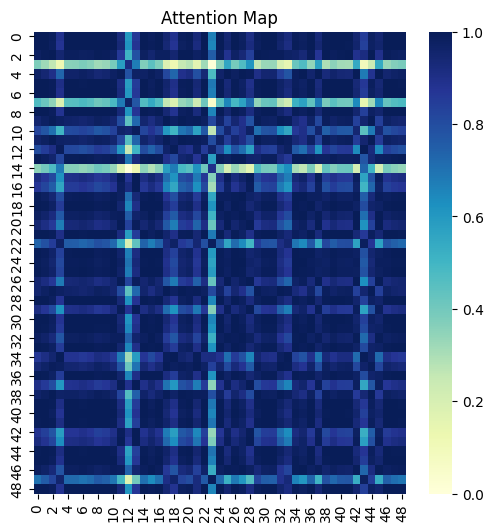

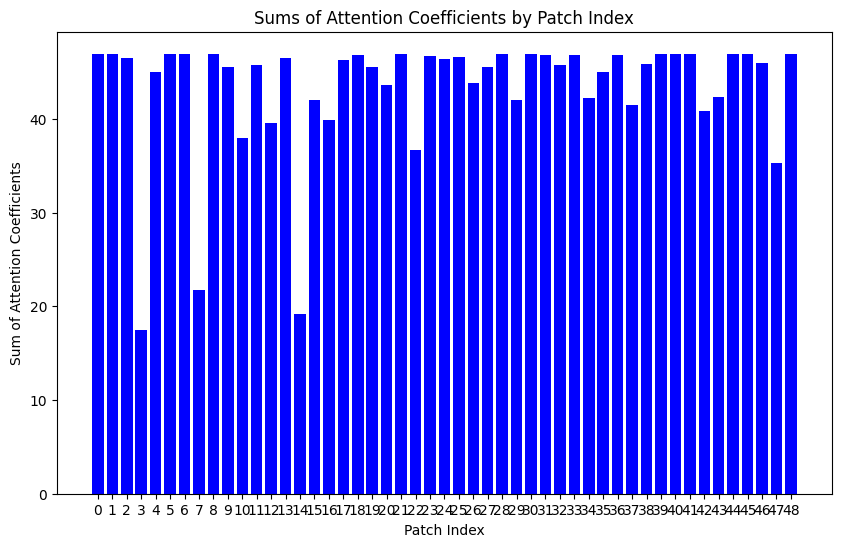

Predicted class for sample 17: 1.0
Row sums: [46.316788 46.32417  45.727383 17.938921 44.684345 46.27498  46.312393
 22.229467 44.015133 45.456455 28.240627 46.284615 46.125175 46.000145
 18.586239 46.203194 38.163483 45.960796 45.956512 46.32466  43.38816
 46.277897 35.8621   46.140865 45.910263 46.32137  43.56365  44.70756
 46.32255  41.884495 44.6747   46.318214 45.890152 44.680767 39.729588
 44.211662 46.231186 38.86357  46.32099  36.48832  46.324196 46.242462
 40.770367 42.217754 46.208702 46.325005 45.491158 34.458656 46.32473 ]


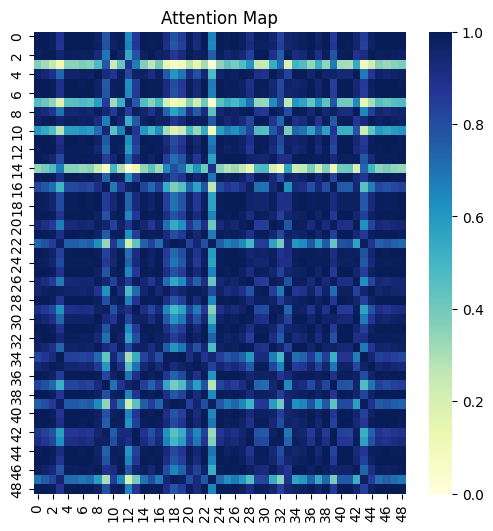

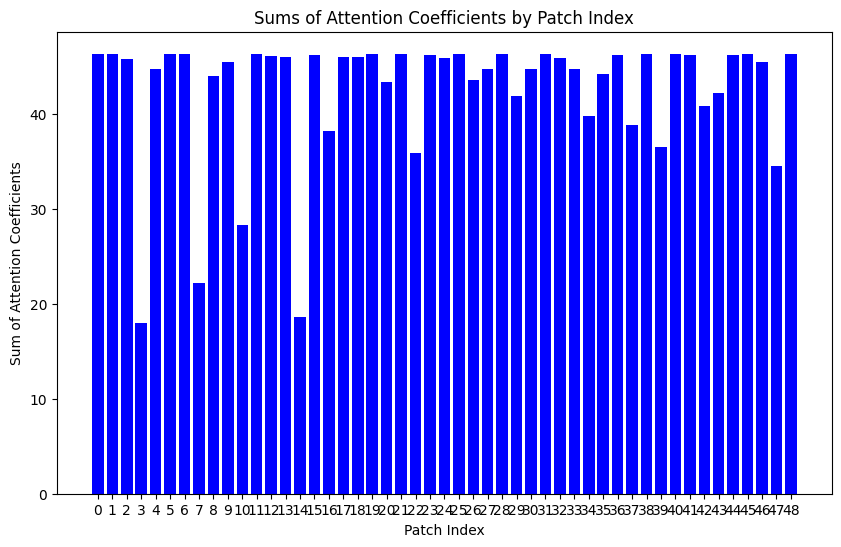

Predicted class for sample 18: 1.0
Row sums: [46.834225 46.784863 46.5465   16.317696 44.50851  46.85427  46.839993
 20.6105   46.801846 45.491714 45.918102 45.352165 46.805187 46.193462
 19.660988 46.853962 45.81567  46.830433 46.663147 46.807964 42.98449
 46.854137 37.29317  46.407364 43.2551   41.05522  43.187283 45.718365
 46.7734   41.276093 46.785072 42.279194 46.560192 46.598843 42.637157
 45.285233 46.556828 40.503895 44.327698 46.854305 46.782196 46.850864
 40.035004 41.650925 46.84143  46.800964 45.507915 35.895504 46.80723 ]


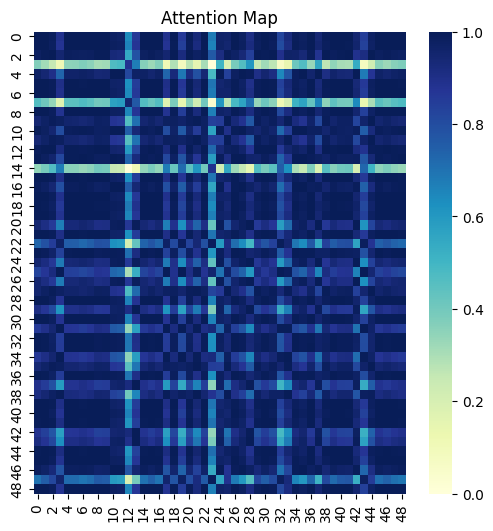

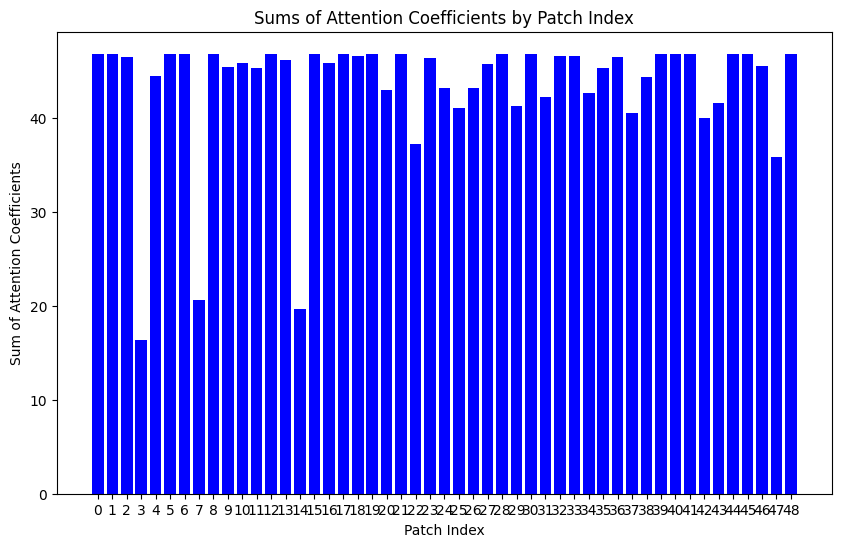

Predicted class for sample 19: 0.0
Row sums: [46.694305 46.65163  46.373016 16.534037 44.45794  46.70719  46.698887
 20.819025 46.666695 45.380383 46.4604   42.062725 46.64675  46.09326
 19.461601 46.70753  46.682045 44.410103 45.011627 46.67205  42.966927
 46.707413 37.066326 46.23165  46.282097 42.78593  43.16566  45.52548
 46.641342 41.289845 46.67494  37.299587 43.061783 46.47959  42.41937
 45.08637  46.439976 40.27127  42.442505 46.707325 46.649246 46.700466
 40.06902  41.658188 46.688282 46.66592  45.430866 35.66883  46.671413]


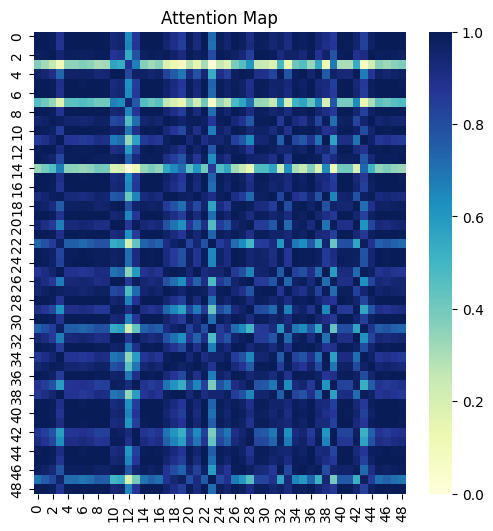

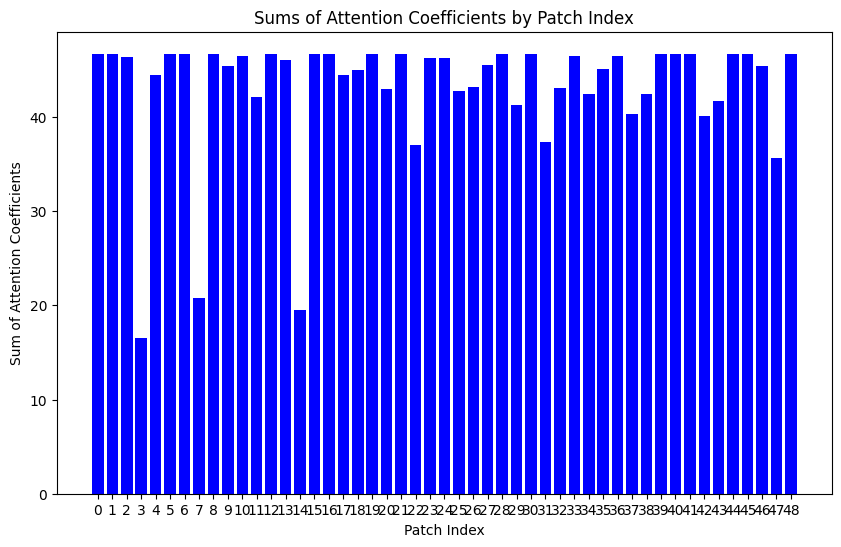

Predicted class for sample 20: 0.0
Row sums: [46.503098 46.511536 45.898697 17.819502 44.85695  46.45956  46.498455
 22.152533 45.768246 45.79825  41.973442 46.479733 46.305576 46.186775
 18.26668  46.037384 46.15348  43.783092 42.437477 46.50909  43.545532
 46.462578 37.3862   45.866318 46.32903  46.509777 46.196465 46.19156
 46.51006  42.331867 41.094643 36.78555  46.474033 45.758495 41.22421
 44.352192 46.419292 40.982178 40.96743  46.387497 46.51126  46.426018
 40.8966   42.36119  46.391293 46.510128 45.672794 34.413593 46.511745]


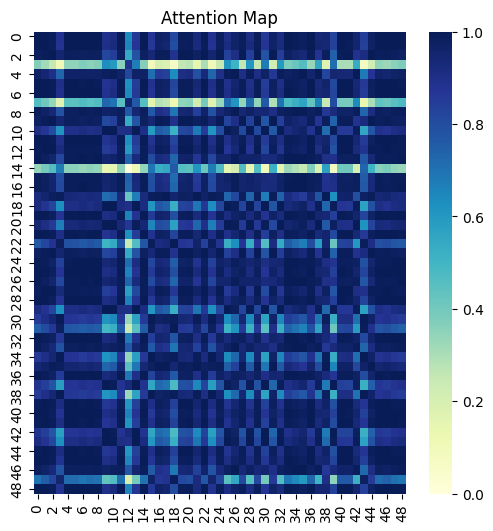

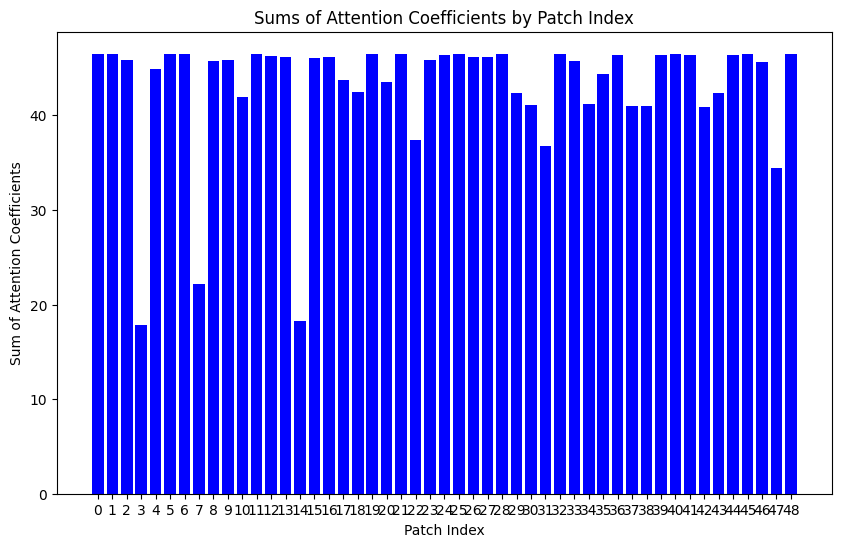

Predicted class for sample 21: 1.0
Row sums: [46.79717  46.764904 46.42098  17.15857  44.68952  46.79873  46.79989
 21.407297 46.777004 45.303234 40.96939  45.524384 38.85789  46.255848
 19.587048 45.133205 46.400013 46.316517 46.621273 43.215218 43.241947
 46.79951  37.091743 46.447662 46.369835 46.707836 43.43543  45.53926
 46.75642  41.604816 46.776325 45.422657 46.336967 46.614132 42.38669
 45.08921  46.578102 45.263477 38.978134 46.797688 46.76295  46.786686
 40.409412 41.964954 42.977173 46.799454 45.626297 35.628933 46.780685]


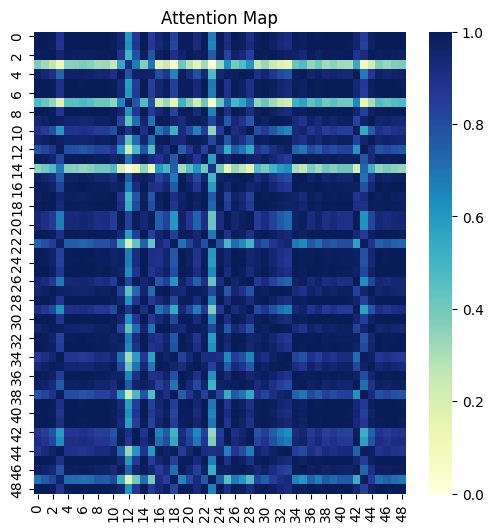

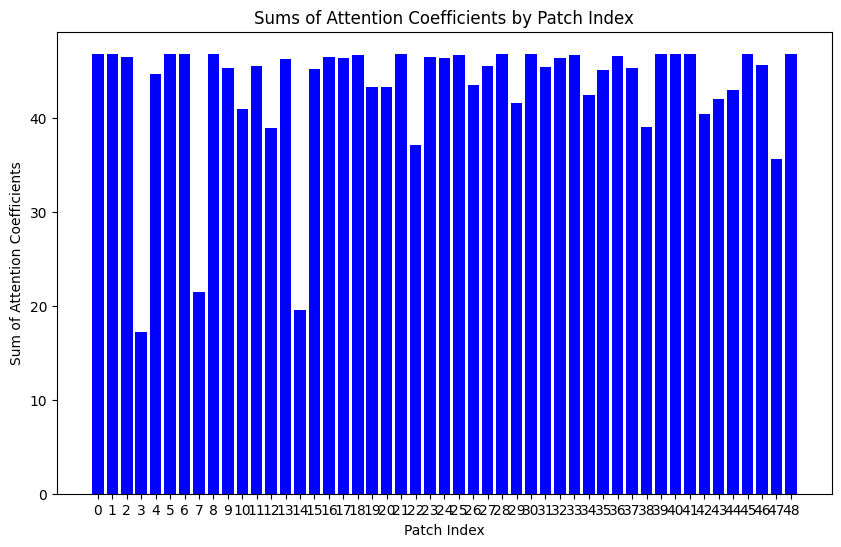

Predicted class for sample 22: 1.0
Row sums: [46.59932  46.55409  46.295277 16.51689  44.343803 46.61521  46.604378
 20.782084 44.91783  46.554874 20.677256 46.600334 46.560223 45.986195
 19.527592 46.564384 39.366302 45.875786 45.679012 46.57551  42.851814
 46.615276 34.868164 45.888203 46.12434  46.532627 46.603767 45.46287
 46.54338  44.14424  46.35454  46.57004  46.512527 46.37745  42.390125
 45.02972  46.33713  40.049446 46.38454  46.155014 46.551605 46.60999
 39.95746  41.54404  46.599102 46.517338 28.650278 35.68463  46.574833]


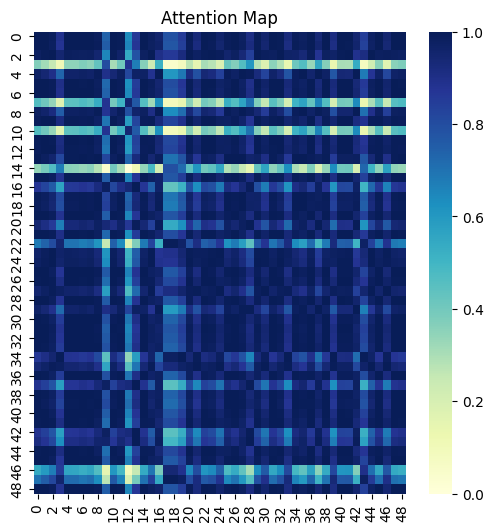

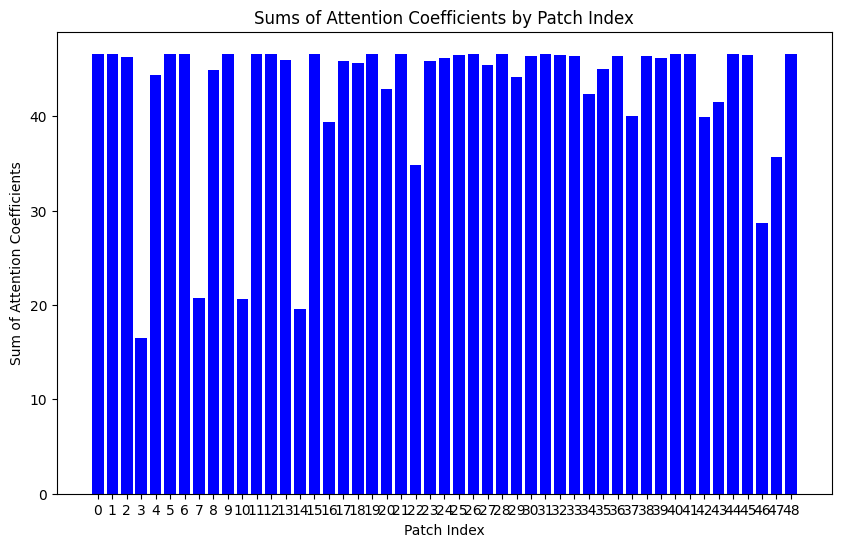

Predicted class for sample 23: 1.0
Row sums: [47.0617   46.9928   46.876514 15.83779  44.495636 47.102966 47.070957
 20.124887 47.015358 45.895977 40.428883 45.637238 47.088253 46.308838
 19.958372 47.10075  45.89483  47.1044   45.758095 47.02368  42.892715
 47.101795 37.795483 46.44009  45.76855  42.09899  43.10493  46.111515
 46.977943 41.113873 47.04176  37.41035  46.208214 46.766846 43.115158
 45.698444 46.718105 40.79226  43.575096 47.104244 46.989326 47.10952
 39.82942  41.502968 47.108395 47.014164 45.56194  36.393238 47.02268 ]


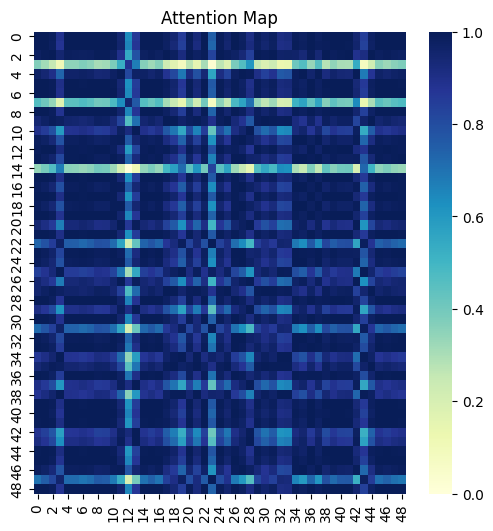

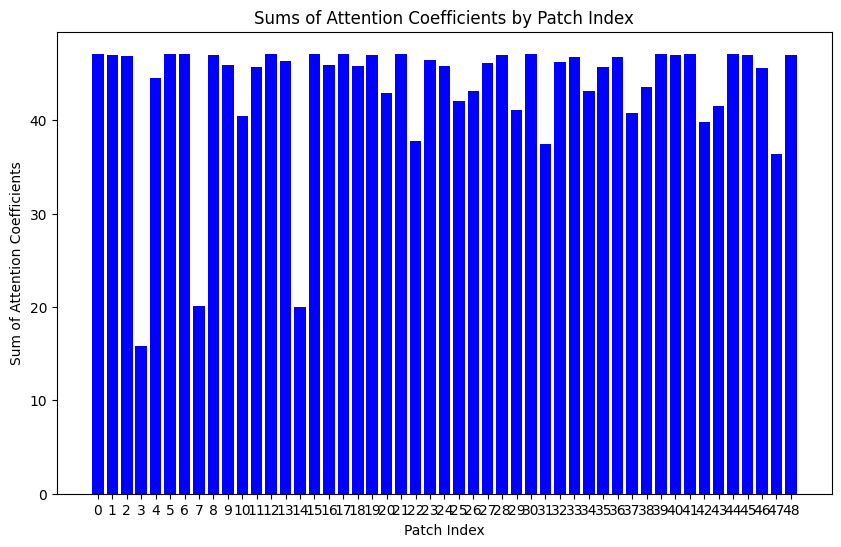

Predicted class for sample 24: 0.0
Row sums: [46.65752  46.608883 46.374203 16.489939 44.365383 46.677277 46.663204
 20.745747 46.625618 45.33559  46.312355 46.03004  46.628944 46.026176
 19.86685  46.67697  45.653866 46.39467  46.040535 46.63165  42.86259
 46.677147 37.261734 46.23491  43.870396 40.967087 43.062588 45.558758
 46.59759  41.177383 46.62946  42.443043 46.387535 46.425617 42.524864
 45.13228  46.38422  40.01609  44.097565 46.677307 46.60626  46.673923
 39.95275  41.54718  46.66464  46.62475  45.350555 35.88478  46.630928]


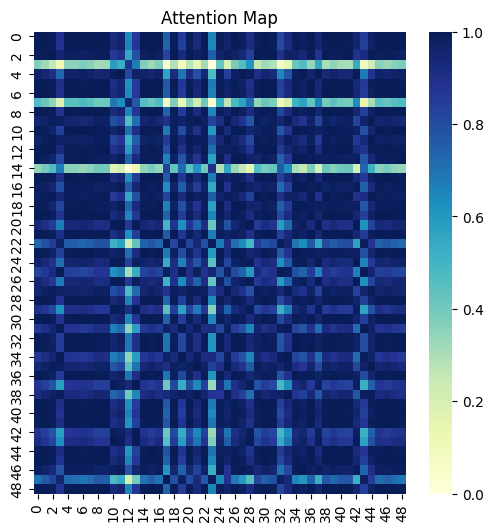

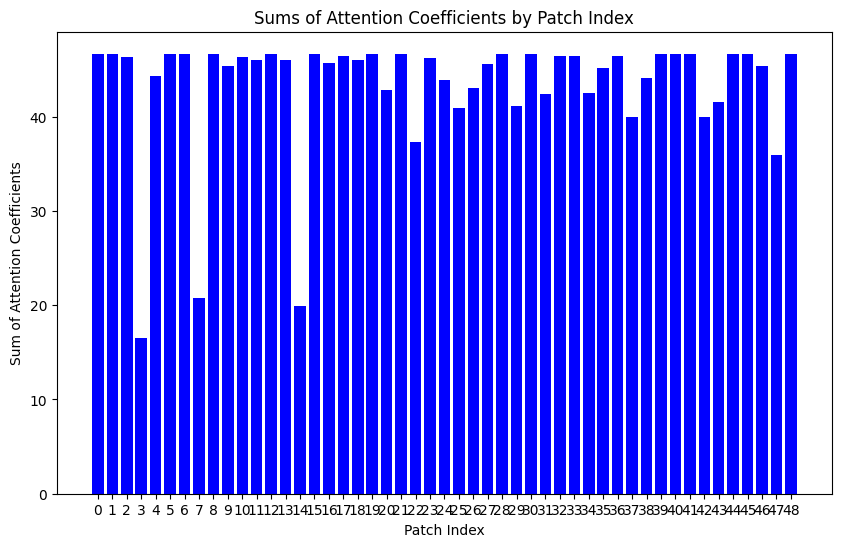

Predicted class for sample 25: 0.0
Row sums: [46.598022 46.539227 46.374283 16.360083 44.198673 40.41054  46.605564
 20.580355 46.558826 45.3879   40.79273  42.85036  44.360214 45.91263
 20.050062 46.62786  45.524914 46.63145  46.177433 46.566    42.673782
 46.628506 37.44509  45.969387 46.496483 41.112926 42.876514 45.602547
 46.526207 40.97044  46.61114  43.341717 46.29515  46.33619  42.646633
 45.19169  46.29159  46.612503 46.38726  46.629925 46.53619  46.63137
 39.736847 41.343567 46.626755 46.5578   45.211468 36.077095 46.56514 ]


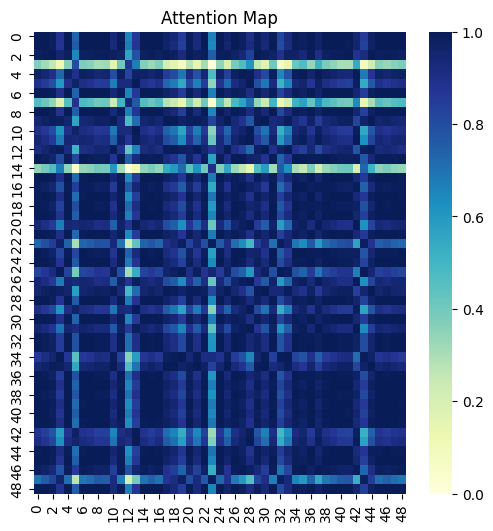

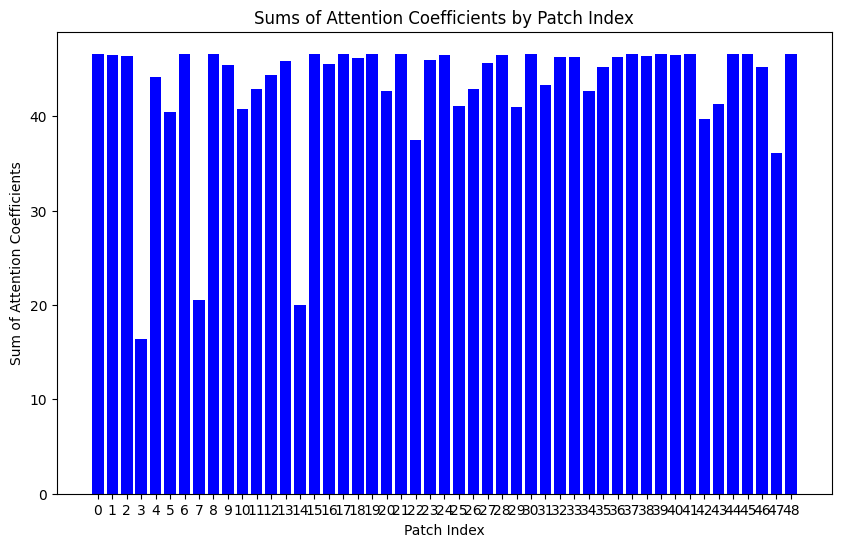

Predicted class for sample 26: 0.0
Row sums: [46.94247  46.90844  46.56762  16.78914  44.78648  46.94546  46.945465
 21.099937 46.92108  45.43912  33.990704 44.686565 36.69591  46.385582
 19.419456 43.390762 43.544445 46.921658 46.719112 46.783455 43.310787
 46.94618  37.0587   46.579742 46.26618  46.50046  46.891144 45.677673
 46.899605 41.64278  46.9086   46.309883 46.848145 46.75277  42.488434
 45.22274  46.715748 43.60825  46.072834 44.09788  46.906403 46.933895
 40.425217 42.00965  46.744907 46.91626  45.742287 35.648163 46.924953]


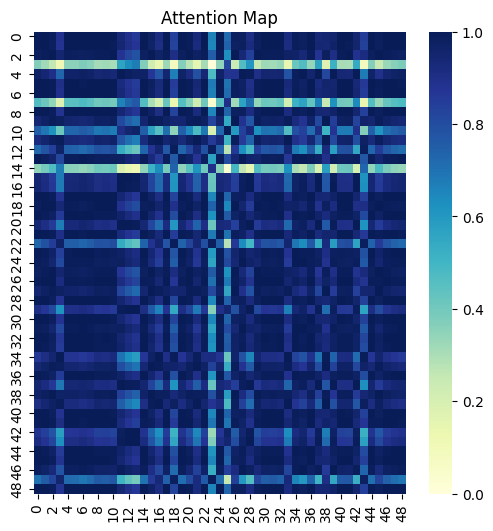

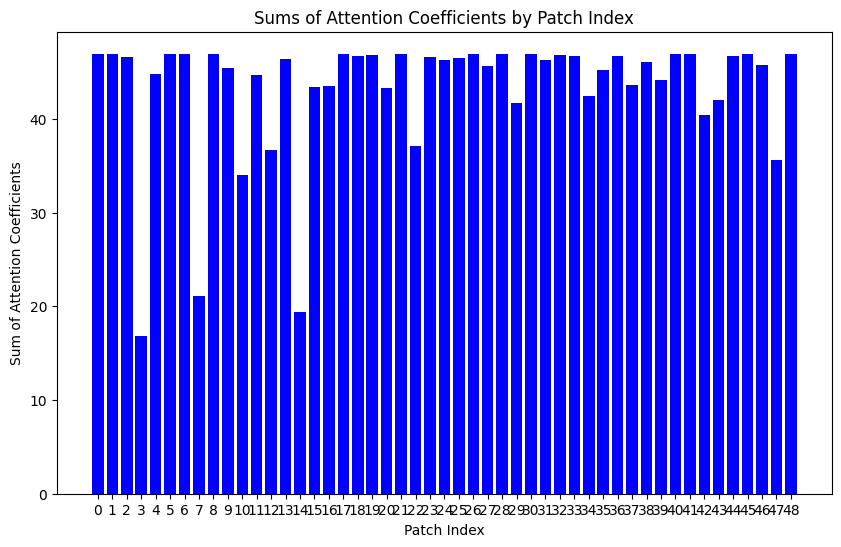

Predicted class for sample 27: 1.0


KeyboardInterrupt: 

In [30]:
for i in range(len(X_test)):
    single_sample = torch.tensor(X_test[i:i+1].astype(np.float32))
    with torch.no_grad():
        prediction = attention_model(single_sample).squeeze()
        predicted_class = (torch.round(prediction)).item()
        print(f"Predicted class for sample {i}: {predicted_class}")


In [24]:
# for i in range(len(X_train)):
#     single_sample = torch.tensor(X_train[i:i+1].astype(np.float32))
#     with torch.no_grad():
#         prediction = attention_model(single_sample).squeeze()
#         predicted_class = (torch.round(torch.sigmoid(prediction))).item()
#         print(f"Predicted class for sample {i}: {predicted_class}")
